# TESS Atlas fit for TOI 202

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 202.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-202.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-202.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-202.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 202

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 202 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

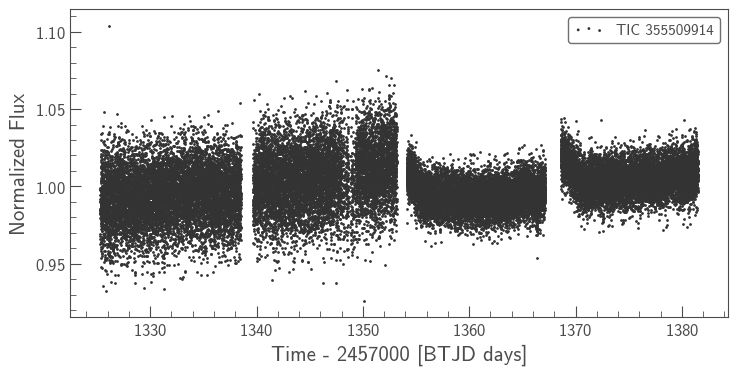

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -155941.47739014158 -> -154435.71797770957


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -147277.09974231586 -> -145804.2116488169


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -145804.2116488169 -> -144715.86787838791


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -144715.86787838791 -> -144715.86476462142


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -144715.86476462142 -> -144715.29748846786


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -144715.29748846786 -> -144715.23006519311


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Optimization terminated successfully.
logp: -144715.23006519311 -> -144660.5102499816


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -144660.5102499816 -> -144660.5102499816


optimizing logp for variables: ['mean', 'rb_radiusimpact__']
message: Optimization terminated successfully.
logp: -144660.5102499816 -> -144660.5102499816


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -144660.5102499816 -> -144660.5102499816


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -144660.5102499816 -> -144660.5102499816


optimizing logp for variables: ['mean', 'rb_radiusimpact__']
message: Optimization terminated successfully.
logp: -144660.5102499816 -> -144660.5102499816


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Optimization terminated successfully.
logp: -144660.5102499816 -> -144660.5102499816


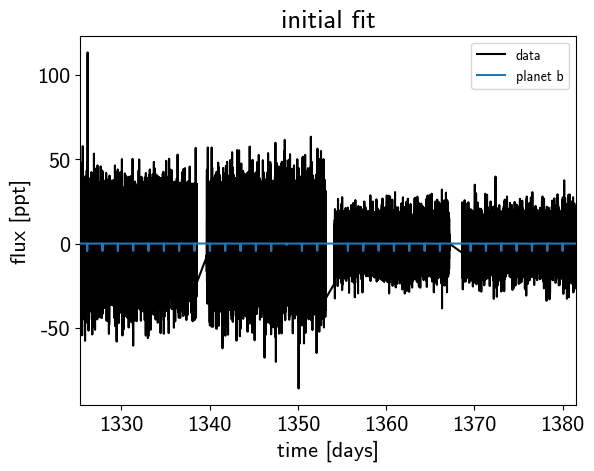

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:01<00:12,  7.40draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:01<00:25,  3.65draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:02<00:27,  3.35draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:03<00:43,  2.10draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:04<00:43,  2.06draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:04<00:44,  1.99draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:04<00:40,  2.17draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:05<00:50,  1.73draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:05<00:37,  2.29draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:06<00:49,  1.71draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:07<00:40,  2.09draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:07<00:45,  1.84draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:08<00:44,  1.82draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:08<00:40,  2.00draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:09<00:47,  1.67draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:10<00:44,  1.75draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:10<00:35,  2.14draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:11<00:41,  1.84draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:11<00:37,  1.98draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:12<00:38,  1.94draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:12<00:34,  2.11draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:13<00:28,  2.54draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:13<00:34,  2.03draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:14<00:33,  2.10draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:14<00:34,  2.02draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:15<00:35,  1.91draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:15<00:32,  2.07draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:16<00:37,  1.76draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:16<00:30,  2.14draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:17<00:39,  1.62draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:18<00:36,  1.72draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:19<00:32,  1.89draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:19<00:31,  1.90draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:20<00:36,  1.63draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:20<00:27,  2.08draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:21<00:35,  1.60draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:21<00:27,  2.04draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:22<00:31,  1.72draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:23<00:29,  1.85draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:24<00:27,  1.87draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:24<00:23,  2.15draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:24<00:25,  1.94draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:25<00:27,  1.81draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:25<00:22,  2.14draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:26<00:28,  1.64draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:27<00:25,  1.74draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:27<00:20,  2.20draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:28<00:23,  1.83draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:29<00:21,  1.98draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:29<00:21,  1.91draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:30<00:21,  1.83draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:30<00:19,  1.99draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:31<00:23,  1.62draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:31<00:20,  1.84draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:32<00:22,  1.59draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:32<00:17,  2.04draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:33<00:21,  1.58draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:34<00:19,  1.68draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:35<00:15,  2.02draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:35<00:16,  1.80draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:36<00:15,  1.86draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:36<00:14,  1.95draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:37<00:15,  1.73draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:37<00:12,  2.07draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:38<00:15,  1.60draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:39<00:13,  1.66draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:40<00:11,  1.75draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:41<00:08,  2.23draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:41<00:10,  1.81draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:42<00:09,  1.96draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:42<00:08,  1.95draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:43<00:09,  1.72draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:44<00:08,  1.82draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:44<00:08,  1.67draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:44<00:06,  2.04draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:45<00:07,  1.54draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:47<00:08,  1.23draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:48<00:09,  1.09draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:48<00:07,  1.26draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:49<00:06,  1.30draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:50<00:06,  1.12draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:51<00:05,  1.01draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:53<00:05,  1.03s/draws]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:54<00:04,  1.04s/draws]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:55<00:03,  1.07s/draws]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:56<00:02,  1.09s/draws]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:57<00:01,  1.12s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:02<00:00,  2.13s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:01, 79.99draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:11,  7.67draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:24,  3.74draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:31,  2.78draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:04<00:32,  2.70draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:42,  2.01draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:33,  2.55draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:06<00:48,  1.73draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:06<00:44,  1.83draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:07<00:37,  2.14draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:07<00:41,  1.91draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:08<00:42,  1.87draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:08<00:38,  2.00draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:09<00:46,  1.65draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:09<00:36,  2.09draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:10<00:46,  1.62draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:10<00:35,  2.11draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:11<00:41,  1.74draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:12<00:36,  1.98draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:12<00:38,  1.84draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:13<00:37,  1.88draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:13<00:35,  1.94draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:14<00:39,  1.74draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:14<00:32,  2.06draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:15<00:40,  1.62draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:15<00:30,  2.12draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:16<00:38,  1.64draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:17<00:36,  1.69draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:18<00:27,  2.20draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:18<00:33,  1.76draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:19<00:31,  1.86draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:19<00:29,  1.90draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:20<00:33,  1.68draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:20<00:25,  2.12draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:21<00:33,  1.59draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:22<00:30,  1.72draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:23<00:24,  2.07draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:24<00:25,  1.92draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:25<00:24,  1.95draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:25<00:20,  2.24draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:26<00:23,  1.94draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:26<00:23,  1.84draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:27<00:21,  2.02draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:28<00:26,  1.58draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:28<00:21,  1.89draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:29<00:27,  1.47draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:30<00:24,  1.56draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:31<00:21,  1.69draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:31<00:16,  2.11draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:32<00:19,  1.78draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:32<00:16,  1.98draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:33<00:16,  1.91draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:34<00:17,  1.78draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:34<00:15,  1.96draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:35<00:18,  1.58draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:35<00:13,  2.07draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:36<00:17,  1.57draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:36<00:13,  1.99draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:37<00:15,  1.66draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:38<00:14,  1.69draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:38<00:12,  1.88draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:39<00:13,  1.64draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:39<00:10,  2.04draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:40<00:12,  1.62draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:41<00:10,  1.70draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:41<00:07,  2.25draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:42<00:06,  2.15draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:42<00:05,  2.70draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:43<00:07,  1.78draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:44<00:05,  2.10draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:45<00:06,  1.46draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:46<00:07,  1.20draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:47<00:07,  1.09draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:47<00:04,  1.43draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:48<00:03,  1.56draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:49<00:03,  1.30draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:50<00:03,  1.16draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:51<00:02,  1.05draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:52<00:01,  1.01draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:53<00:01,  1.02s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [00:58<00:00,  2.06s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<03:21,  1.01draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:01<02:30,  1.34draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:49,  1.83draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:02<02:05,  1.58draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:47,  1.84draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:03<01:50,  1.78draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<01:56,  1.69draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:04<01:40,  1.95draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:05<02:07,  1.53draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:05<01:37,  1.97draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:06<01:44,  1.82draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:06<01:32,  2.05draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:06<01:32,  2.04draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:07<01:31,  2.05draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:08<02:00,  1.55draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:09<01:55,  1.60draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:10<01:46,  1.71draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:10<01:28,  2.06draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:10<01:05,  2.77draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:11<00:52,  3.39draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:11<01:14,  2.37draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:11<00:55,  3.16draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:12<01:31,  1.92draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:13<01:11,  2.43draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:13<01:32,  1.87draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:14<01:22,  2.09draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:14<01:18,  2.17draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:15<01:34,  1.80draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:15<01:18,  2.17draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:16<01:43,  1.63draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:16<01:16,  2.17draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:17<01:44,  1.59draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:17<01:18,  2.11draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:18<01:37,  1.68draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:19<01:45,  1.55draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:19<01:25,  1.90draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:20<01:46,  1.51draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:21<01:41,  1.57draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:22<01:18,  2.02draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:22<01:32,  1.69draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:23<01:16,  2.04draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:23<01:01,  2.53draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:24<01:08,  2.25draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:24<01:00,  2.52draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:24<00:54,  2.79draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:25<01:20,  1.85draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:26<01:17,  1.91draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:27<01:05,  2.24draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:27<00:52,  2.79draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:27<01:00,  2.39draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:28<00:57,  2.51draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:28<01:05,  2.17draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:29<01:05,  2.15draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:30<01:02,  2.25draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:30<01:06,  2.08draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:31<01:26,  1.60draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:32<01:18,  1.73draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:33<01:15,  1.79draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:33<01:08,  1.95draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:34<01:25,  1.56draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:34<01:13,  1.80draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:35<01:14,  1.77draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:36<01:20,  1.61draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:36<01:01,  2.08draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:37<01:17,  1.65draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:37<00:59,  2.12draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:38<01:09,  1.81draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:38<01:04,  1.95draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:39<01:05,  1.90draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:39<01:08,  1.80draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:40<01:02,  1.95draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:40<01:11,  1.69draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:41<00:57,  2.07draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:42<01:16,  1.55draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:42<00:57,  2.05draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:43<01:15,  1.55draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:44<01:10,  1.63draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:44<00:58,  1.96draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:45<00:51,  2.16draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:45<00:54,  2.05draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:46<00:52,  2.10draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:47<00:59,  1.84draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:47<00:49,  2.17draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:48<01:02,  1.72draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:48<00:47,  2.25draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:49<01:03,  1.65draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:50<00:59,  1.73draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:50<00:48,  2.12draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:51<00:56,  1.79draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:51<00:51,  1.94draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:52<00:53,  1.85draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:52<00:53,  1.83draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:53<00:48,  1.98draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:54<00:54,  1.75draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:54<00:44,  2.12draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:55<00:57,  1.65draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:56<00:52,  1.74draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:56<00:41,  2.18draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:56<00:37,  2.42draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:57<00:46,  1.91draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:57<00:35,  2.48draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:58<00:55,  1.55draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:59<00:53,  1.60draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [01:00<00:38,  2.14draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [01:01<00:50,  1.62draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [01:01<00:38,  2.06draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [01:01<00:30,  2.55draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [01:02<00:34,  2.22draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [01:02<00:29,  2.52draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [01:03<00:28,  2.59draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [01:03<00:25,  2.81draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [01:04<00:30,  2.40draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [01:04<00:35,  2.01draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [01:05<00:30,  2.29draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [01:06<00:38,  1.77draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [01:07<00:36,  1.83draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [01:07<00:28,  2.35draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [01:07<00:34,  1.89draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [01:08<00:30,  2.08draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [01:08<00:28,  2.21draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [01:08<00:22,  2.76draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [01:09<00:32,  1.89draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [01:10<00:30,  1.95draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [01:10<00:24,  2.35draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [01:11<00:23,  2.39draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [01:12<00:23,  2.30draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [01:12<00:17,  2.95draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [01:12<00:14,  3.68draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [01:13<00:18,  2.83draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [01:13<00:21,  2.32draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [01:14<00:21,  2.30draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [01:15<00:32,  1.50draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [01:16<00:28,  1.61draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:16<00:25,  1.80draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:17<00:22,  1.92draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:18<00:27,  1.58draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:18<00:21,  1.89draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:19<00:23,  1.71draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:19<00:19,  2.05draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:20<00:24,  1.57draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:21<00:21,  1.69draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:21<00:17,  2.06draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:22<00:14,  2.38draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:22<00:16,  1.94draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:23<00:15,  2.03draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:23<00:15,  2.06draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:24<00:15,  1.97draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:24<00:15,  1.83draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:25<00:13,  2.08draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [01:26<00:16,  1.66draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:26<00:12,  2.06draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:27<00:15,  1.58draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:28<00:16,  1.46draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:28<00:14,  1.62draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:29<00:17,  1.24draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:31<00:19,  1.09draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:32<00:19,  1.04draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:33<00:19,  1.03s/draws]

Sampling 2 chains:  91%|█████████ | 186/204 [01:33<00:16,  1.12draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [01:35<00:16,  1.01draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:36<00:16,  1.04s/draws]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:36<00:13,  1.08draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:37<00:11,  1.27draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:38<00:11,  1.08draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:39<00:12,  1.03s/draws]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:41<00:11,  1.05s/draws]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:42<00:10,  1.06s/draws]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:42<00:07,  1.15draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:42<00:05,  1.35draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:43<00:05,  1.21draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:45<00:05,  1.10draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:46<00:05,  1.16s/draws]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:48<00:05,  1.36s/draws]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:50<00:04,  1.50s/draws]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:51<00:02,  1.49s/draws]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:52<00:01,  1.21s/draws]

Sampling 2 chains: 100%|██████████| 204/204 [01:53<00:00,  1.08s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/404 [00:00<00:21, 18.38draws/s]

Sampling 2 chains:   1%|          | 4/404 [00:00<00:29, 13.76draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:24, 16.36draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:20, 18.88draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:17, 21.83draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:00<00:18, 20.65draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:00<00:18, 21.01draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:01<00:16, 22.70draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:01<00:17, 22.02draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:01<00:18, 20.23draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:25, 14.76draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:01<00:30, 12.07draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:02<00:33, 10.85draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:02<00:28, 12.59draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:02<00:32, 11.17draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:02<00:28, 12.57draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:02<00:30, 11.68draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:03<00:29, 12.22draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:03<00:25, 13.76draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:03<00:21, 16.16draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:03<00:24, 14.43draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:03<00:22, 15.29draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:03<00:20, 16.68draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:03<00:19, 17.54draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:04<00:16, 20.28draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:04<00:15, 21.56draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:04<00:15, 20.50draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:04<00:14, 22.43draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:04<00:15, 21.04draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:04<00:15, 20.54draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:05<00:15, 20.01draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:05<00:14, 21.53draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:05<00:13, 22.49draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:05<00:12, 23.74draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:05<00:11, 26.83draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:05<00:13, 21.92draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:05<00:14, 20.88draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:06<00:16, 17.48draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:06<00:15, 18.27draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:06<00:15, 17.99draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:06<00:16, 16.73draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:06<00:15, 18.17draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:06<00:15, 18.15draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:06<00:15, 17.78draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:07<00:15, 17.90draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:07<00:13, 20.60draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:07<00:13, 19.71draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:07<00:12, 21.16draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:07<00:10, 24.47draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:07<00:10, 24.51draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:07<00:10, 23.17draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:07<00:10, 24.38draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:08<00:10, 24.72draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:08<00:10, 23.63draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:08<00:11, 20.32draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:08<00:11, 20.66draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:08<00:10, 21.61draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:08<00:09, 24.30draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:09<00:09, 23.46draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:09<00:10, 21.70draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:09<00:11, 19.77draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:09<00:11, 19.05draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:09<00:11, 19.47draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:09<00:09, 21.27draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:09<00:09, 22.68draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:10<00:08, 24.30draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:10<00:08, 24.14draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:10<00:08, 23.15draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:10<00:08, 24.30draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:10<00:09, 20.41draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:10<00:08, 23.34draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:10<00:06, 26.72draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:11<00:06, 26.42draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:11<00:05, 29.68draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:11<00:06, 27.78draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:11<00:06, 27.48draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:11<00:06, 24.17draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:11<00:06, 25.00draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:11<00:06, 25.21draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:12<00:07, 21.33draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:12<00:06, 22.21draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:12<00:06, 23.68draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:12<00:05, 24.71draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:12<00:05, 24.81draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:12<00:05, 25.96draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:12<00:06, 21.71draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:13<00:06, 21.83draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:13<00:06, 19.13draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:13<00:05, 21.16draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:13<00:05, 22.04draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:13<00:05, 21.96draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:13<00:05, 19.91draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:14<00:06, 18.04draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:14<00:05, 20.37draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:14<00:06, 16.13draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:14<00:07, 14.11draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:14<00:07, 13.92draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:14<00:06, 15.02draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:15<00:05, 17.25draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:15<00:06, 13.62draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:15<00:05, 16.23draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:15<00:05, 17.66draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:15<00:04, 18.61draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:15<00:03, 20.56draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:15<00:03, 22.02draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:15<00:03, 22.81draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:16<00:03, 24.24draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:16<00:03, 22.78draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:16<00:02, 23.85draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:16<00:03, 21.25draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:16<00:02, 25.59draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:16<00:02, 23.50draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:16<00:02, 21.62draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:17<00:01, 24.42draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:17<00:02, 19.44draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:17<00:01, 21.15draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:17<00:01, 23.24draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:17<00:01, 19.59draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:17<00:01, 21.67draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:18<00:01, 19.96draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:18<00:00, 24.01draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:18<00:00, 25.52draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:18<00:00, 26.29draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:18<00:00, 28.58draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:18<00:00, 27.73draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:18<00:00, 23.95draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:19<00:00, 21.91draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:19<00:00, 20.86draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:37, 21.42draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:31, 25.03draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:28, 27.88draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:27, 28.15draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:27, 28.15draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:00<00:28, 27.33draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:00<00:26, 29.67draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:00<00:24, 31.12draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:28, 27.36draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:01<00:24, 30.91draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:01<00:20, 36.05draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:01<00:19, 37.80draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:01<00:19, 38.50draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:01<00:21, 34.02draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:02<00:27, 27.19draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:02<00:27, 27.05draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:02<00:23, 30.74draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:02<00:23, 30.87draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:02<00:23, 31.17draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:02<00:22, 32.47draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:02<00:24, 29.08draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:02<00:22, 31.59draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:03<00:21, 32.72draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:03<00:21, 32.44draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:03<00:26, 26.63draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:03<00:27, 25.60draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:03<00:25, 27.13draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:03<00:23, 29.58draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:03<00:20, 33.11draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:04<00:20, 32.34draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:04<00:21, 31.69draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:04<00:22, 29.50draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:04<00:26, 25.42draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:04<00:24, 27.21draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:04<00:24, 26.42draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:04<00:22, 28.86draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:05<00:20, 31.53draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:05<00:19, 33.50draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:05<00:20, 30.75draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:05<00:20, 30.69draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:05<00:19, 31.87draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:05<00:22, 28.36draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:05<00:22, 27.92draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:06<00:21, 28.22draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:06<00:22, 27.82draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:06<00:24, 24.82draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:06<00:22, 26.76draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:06<00:23, 26.14draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:06<00:24, 24.91draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:06<00:22, 26.21draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:06<00:18, 32.16draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:07<00:17, 33.94draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:07<00:16, 34.96draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:07<00:19, 29.47draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:07<00:19, 30.05draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:07<00:18, 30.95draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:07<00:20, 28.08draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:08<00:23, 23.70draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:08<00:26, 21.11draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:08<00:27, 20.49draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [00:08<00:27, 19.97draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:08<00:25, 21.16draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:08<00:26, 20.23draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:09<00:30, 17.65draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:09<00:34, 15.44draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:09<00:30, 17.37draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:09<00:32, 16.56draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:09<00:29, 17.97draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:09<00:31, 16.91draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:09<00:32, 16.32draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:09<00:31, 16.58draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:10<00:33, 15.78draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [00:10<00:33, 15.64draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:10<00:32, 15.87draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:10<00:34, 15.12draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:10<00:35, 14.34draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:11<00:54,  9.35draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:11<00:51,  9.96draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:11<00:59,  8.56draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:11<00:52,  9.74draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:11<00:46, 10.79draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:11<00:43, 11.51draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:12<00:41, 12.08draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:12<00:34, 14.38draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:12<00:34, 14.50draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:12<00:32, 15.36draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:12<00:28, 17.29draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:12<00:27, 17.59draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:12<00:25, 19.10draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:13<00:29, 16.45draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:13<00:31, 15.13draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:13<00:30, 15.73draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:13<00:32, 14.89draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:13<00:30, 15.78draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:13<00:26, 18.08draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:13<00:22, 20.40draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:13<00:21, 21.28draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:14<00:20, 22.16draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:14<00:21, 21.63draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:14<00:20, 22.53draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:14<00:19, 23.32draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:14<00:18, 24.06draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:14<00:17, 25.74draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:14<00:18, 23.65draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:14<00:16, 26.18draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:15<00:15, 28.68draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:15<00:15, 27.52draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:15<00:14, 30.19draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:15<00:13, 32.13draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:15<00:15, 26.76draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:15<00:15, 27.48draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [00:15<00:15, 27.37draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:16<00:15, 25.84draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:16<00:15, 26.35draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:16<00:15, 26.37draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:16<00:14, 26.75draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:16<00:13, 28.99draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:16<00:13, 29.85draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:16<00:11, 34.05draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:16<00:10, 36.65draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [00:17<00:09, 37.76draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:17<00:08, 40.98draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:17<00:09, 39.27draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:17<00:09, 36.40draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:17<00:10, 34.36draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:17<00:10, 34.64draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:17<00:09, 36.04draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:17<00:09, 34.89draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:18<00:10, 33.53draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:18<00:10, 32.81draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:18<00:09, 33.33draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:18<00:10, 31.66draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:18<00:10, 30.00draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:18<00:10, 30.91draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:18<00:09, 33.44draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:19<00:09, 32.90draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:19<00:08, 34.09draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:19<00:07, 37.64draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:19<00:06, 42.48draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [00:19<00:06, 46.69draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:19<00:06, 44.27draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:19<00:06, 39.48draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:20<00:07, 36.15draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:20<00:07, 36.78draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [00:20<00:07, 34.60draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:20<00:07, 34.39draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:20<00:06, 36.14draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:20<00:06, 35.44draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:20<00:06, 35.06draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:20<00:06, 36.04draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:20<00:06, 35.81draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:21<00:05, 40.19draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:21<00:05, 42.50draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:21<00:05, 38.83draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [00:21<00:05, 36.35draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [00:21<00:07, 28.88draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:21<00:07, 28.24draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:21<00:06, 30.58draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [00:22<00:06, 30.26draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:22<00:06, 27.80draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:22<00:06, 30.41draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:22<00:05, 32.44draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:22<00:04, 36.10draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:22<00:05, 31.67draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:22<00:05, 31.51draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:22<00:05, 32.98draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:23<00:04, 33.94draws/s]

Sampling 2 chains:  80%|████████  | 646/804 [00:23<00:04, 33.20draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [00:23<00:04, 33.29draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:23<00:04, 30.44draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:23<00:04, 29.98draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:23<00:04, 28.70draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [00:23<00:04, 27.83draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [00:23<00:04, 28.95draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:24<00:04, 32.46draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:24<00:03, 34.81draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:24<00:03, 32.36draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [00:24<00:03, 34.65draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [00:24<00:03, 34.24draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:24<00:02, 37.58draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [00:24<00:02, 35.12draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [00:24<00:02, 34.71draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:25<00:02, 38.05draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [00:25<00:02, 35.66draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:25<00:02, 31.73draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:25<00:02, 31.76draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [00:25<00:02, 30.28draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:25<00:02, 25.64draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:25<00:02, 25.87draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:26<00:02, 30.24draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:26<00:02, 27.63draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:26<00:02, 23.59draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [00:26<00:02, 22.44draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:26<00:02, 23.46draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [00:26<00:02, 19.14draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:27<00:02, 18.56draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [00:27<00:02, 16.65draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:27<00:02, 16.48draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:27<00:02, 16.05draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:27<00:02, 16.12draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:27<00:02, 14.64draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:28<00:02, 14.43draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [00:28<00:01, 15.36draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:28<00:01, 16.09draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:28<00:01, 16.63draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [00:28<00:01, 17.04draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [00:28<00:01, 18.19draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:28<00:00, 20.16draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:28<00:00, 21.66draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [00:29<00:00, 21.04draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:29<00:00, 18.91draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:29<00:00, 18.31draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:29<00:00, 17.87draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:29<00:00, 18.71draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<07:48,  9.41draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<05:59, 12.24draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<05:00, 14.63draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<04:31, 16.20draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<04:00, 18.26draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:00<04:39, 15.71draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:01<05:41, 12.82draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:01<05:19, 13.71draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:01<10:16,  7.10draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:02<10:43,  6.80draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:02<11:37,  6.27draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:02<09:22,  7.77draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:02<08:43,  8.36draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:02<07:06, 10.24draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:03<05:52, 12.38draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:03<05:13, 13.93draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:03<05:24, 13.44draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:03<04:42, 15.43draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:03<04:30, 16.07draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:03<04:20, 16.74draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:03<04:12, 17.22draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:04<04:15, 16.98draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:04<04:12, 17.23draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:04<03:50, 18.84draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:04<03:40, 19.67draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:04<03:29, 20.72draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:04<02:59, 24.11draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:04<02:31, 28.56draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:05<02:41, 26.70draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:05<02:51, 25.15draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:05<03:08, 22.84draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:05<03:04, 23.42draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:05<03:26, 20.82draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:05<03:30, 20.42draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:06<03:42, 19.35draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:06<03:44, 19.11draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:06<03:27, 20.73draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:06<03:16, 21.87draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:06<03:05, 23.10draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:06<03:25, 20.86draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:06<03:29, 20.49draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:06<03:14, 22.00draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:07<03:20, 21.37draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:07<03:34, 19.90draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:07<03:32, 20.08draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:07<03:18, 21.50draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:07<03:11, 22.23draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:07<02:57, 24.00draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:07<02:51, 24.84draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:08<02:46, 25.63draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:08<02:46, 25.60draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:08<03:02, 23.27draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:08<02:58, 23.74draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:08<02:58, 23.74draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:08<02:54, 24.27draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:08<02:56, 23.99draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:08<02:50, 24.82draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:09<02:38, 26.64draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:09<02:43, 25.88draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:09<02:36, 26.91draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:09<02:33, 27.50draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:09<02:41, 26.12draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:09<03:13, 21.83draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:09<03:00, 23.36draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:09<03:03, 22.96draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:10<03:32, 19.76draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:10<03:26, 20.40draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:10<03:21, 20.81draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:10<03:46, 18.51draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:10<03:51, 18.10draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:10<03:47, 18.43draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:11<03:34, 19.50draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:11<03:14, 21.57draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:11<03:16, 21.28draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:11<03:06, 22.41draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:11<02:54, 23.96draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:11<02:44, 25.39draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:11<02:28, 28.00draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:11<02:46, 24.94draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:12<03:22, 20.55draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:12<03:06, 22.33draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:12<02:44, 25.20draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:12<02:34, 26.87draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:12<03:09, 21.85draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:12<03:22, 20.48draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:13<03:40, 18.81draws/s]

Sampling 2 chains:   6%|▌         | 267/4404 [00:13<03:40, 18.80draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:13<03:32, 19.41draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:13<03:13, 21.36draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:13<03:12, 21.39draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:13<03:09, 21.81draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:13<02:43, 25.21draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:14<02:36, 26.26draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:14<03:13, 21.23draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:14<03:10, 21.55draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:14<03:03, 22.39draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:14<03:11, 21.44draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:14<03:07, 21.93draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:15<03:48, 17.91draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:15<03:48, 17.96draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:15<03:44, 18.25draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:15<03:56, 17.29draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:15<03:52, 17.57draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:15<03:39, 18.62draws/s]

Sampling 2 chains:   7%|▋         | 320/4404 [00:15<03:23, 20.02draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:15<03:13, 21.12draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:16<03:24, 19.98draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:16<03:10, 21.37draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:16<02:56, 23.02draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:16<02:52, 23.56draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:16<02:34, 26.35draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:16<02:31, 26.87draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:16<02:28, 27.25draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:16<02:31, 26.82draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:17<02:29, 27.10draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:17<02:28, 27.28draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:17<03:06, 21.73draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:17<02:53, 23.37draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:17<02:46, 24.27draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:17<02:46, 24.22draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:17<02:37, 25.55draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:17<02:38, 25.47draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:18<02:41, 24.97draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:18<02:25, 27.64draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:18<02:23, 27.95draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:18<02:12, 30.24draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [00:18<02:09, 31.08draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:18<02:18, 28.83draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:18<02:25, 27.52draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:18<02:30, 26.49draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:19<02:34, 25.82draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:19<02:34, 25.89draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:19<03:12, 20.73draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:19<03:26, 19.29draws/s]

Sampling 2 chains:  10%|▉         | 420/4404 [00:19<03:11, 20.79draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:19<03:00, 22.06draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:20<03:01, 21.86draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:20<02:49, 23.47draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:20<02:57, 22.34draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:20<02:54, 22.73draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:20<03:13, 20.52draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [00:20<02:43, 24.17draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:20<02:58, 22.19draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:21<02:42, 24.26draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:21<02:42, 24.30draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:21<02:51, 23.04draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:21<02:45, 23.83draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:21<02:57, 22.25draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:21<02:43, 24.06draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:21<02:24, 27.18draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:21<02:22, 27.57draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:22<02:25, 26.94draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:22<02:23, 27.44draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:22<02:18, 28.38draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:22<02:11, 29.76draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [00:22<02:29, 26.09draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:22<02:35, 25.13draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:22<02:23, 27.26draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:22<02:22, 27.28draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:23<03:19, 19.59draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:23<03:38, 17.81draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:23<03:39, 17.75draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:23<03:38, 17.79draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:23<03:59, 16.22draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:24<03:59, 16.25draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:24<03:35, 18.05draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:24<03:11, 20.23draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:24<03:03, 21.12draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:24<03:14, 19.88draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:24<03:03, 21.13draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:24<03:03, 21.05draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:25<03:15, 19.76draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:25<03:04, 20.88draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:25<02:57, 21.76draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:25<02:50, 22.56draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:25<03:28, 18.45draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:25<03:47, 16.96draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:25<03:30, 18.25draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:26<03:41, 17.35draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:26<03:54, 16.40draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [00:26<04:07, 15.50draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:26<03:37, 17.65draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:26<03:38, 17.58draws/s]

Sampling 2 chains:  13%|█▎        | 573/4404 [00:26<03:05, 20.62draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [00:26<03:01, 21.08draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:26<03:04, 20.72draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:27<02:54, 21.91draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:27<02:58, 21.45draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:27<02:45, 23.06draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:27<02:36, 24.43draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:27<02:30, 25.27draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:27<02:59, 21.15draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:27<02:35, 24.39draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:28<02:17, 27.56draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [00:28<02:28, 25.49draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:28<02:37, 24.11draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:28<02:34, 24.47draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:28<02:29, 25.31draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:28<02:32, 24.84draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:29<03:02, 20.69draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:29<03:05, 20.29draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:29<02:49, 22.27draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:29<02:41, 23.33draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:29<02:53, 21.63draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:29<02:41, 23.31draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:29<03:12, 19.50draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:30<03:21, 18.63draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [00:30<04:03, 15.41draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:30<03:47, 16.47draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:30<03:27, 18.03draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:30<02:57, 21.07draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:30<02:43, 22.82draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [00:30<02:37, 23.76draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:31<02:30, 24.76draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:31<02:32, 24.51draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:31<02:20, 26.51draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:31<02:33, 24.26draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:31<02:37, 23.63draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [00:31<02:47, 22.18draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:31<02:31, 24.43draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:32<02:58, 20.75draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:32<03:01, 20.44draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:32<02:44, 22.56draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:32<02:33, 24.07draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:32<02:11, 28.03draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:32<01:54, 32.12draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [00:32<01:48, 34.05draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:32<01:41, 36.23draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [00:33<01:43, 35.47draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [00:33<02:05, 29.20draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:33<02:03, 29.73draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:33<01:54, 31.94draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:33<02:05, 29.18draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:33<02:03, 29.55draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [00:33<02:10, 28.03draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:34<02:13, 27.33draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:34<02:10, 27.90draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:34<02:25, 24.95draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:34<02:23, 25.33draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [00:34<02:23, 25.29draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:34<02:19, 26.07draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:34<02:16, 26.47draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [00:34<02:01, 29.85draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [00:35<02:05, 28.71draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [00:35<02:24, 25.08draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [00:35<02:15, 26.62draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:35<02:42, 22.25draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [00:35<02:26, 24.60draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:35<02:17, 26.24draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [00:35<02:37, 22.85draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [00:36<03:01, 19.76draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [00:36<02:56, 20.37draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:36<03:22, 17.74draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [00:36<03:17, 18.15draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [00:36<03:05, 19.36draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:36<02:58, 20.02draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [00:37<02:50, 20.95draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:37<02:47, 21.32draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:37<02:40, 22.29draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:37<02:28, 23.97draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [00:37<02:27, 24.08draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [00:37<02:21, 25.08draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [00:37<02:16, 26.09draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:37<02:08, 27.66draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:38<02:17, 25.83draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:38<02:53, 20.38draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [00:38<02:41, 21.87draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [00:38<02:31, 23.42draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:38<02:20, 25.16draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [00:38<02:12, 26.69draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:38<02:01, 29.07draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [00:39<02:04, 28.37draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [00:39<02:04, 28.32draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [00:39<02:08, 27.32draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [00:39<02:08, 27.31draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:39<02:08, 27.32draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [00:39<02:09, 27.16draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:39<02:07, 27.40draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [00:39<02:05, 27.78draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:40<02:07, 27.52draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [00:40<02:11, 26.57draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [00:40<01:58, 29.36draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [00:40<01:51, 31.18draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:40<01:59, 29.17draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [00:40<01:54, 30.43draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:40<01:53, 30.63draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:40<01:58, 29.16draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [00:41<01:54, 30.12draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:41<01:46, 32.43draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [00:41<01:44, 33.20draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [00:41<01:47, 32.03draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [00:41<01:53, 30.40draws/s]

Sampling 2 chains:  22%|██▏       | 962/4404 [00:41<01:53, 30.30draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:41<01:43, 33.32draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [00:42<01:49, 31.45draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [00:42<02:01, 28.33draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:42<02:02, 27.93draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [00:42<02:01, 28.14draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [00:42<02:16, 24.98draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [00:42<02:23, 23.80draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [00:42<02:10, 26.17draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [00:42<02:01, 27.99draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [00:43<02:01, 28.05draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [00:43<01:55, 29.34draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [00:43<01:56, 29.07draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:43<01:59, 28.51draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [00:43<02:04, 27.22draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [00:43<01:59, 28.25draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [00:43<01:54, 29.66draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [00:43<01:47, 31.43draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [00:44<01:53, 29.64draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [00:44<01:54, 29.52draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [00:44<01:58, 28.51draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [00:44<02:13, 25.25draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [00:44<02:26, 22.87draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [00:44<02:20, 23.87draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [00:45<02:51, 19.53draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [00:45<02:39, 20.96draws/s]

Sampling 2 chains:  24%|██▍       | 1056/4404 [00:45<02:30, 22.20draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [00:45<02:20, 23.86draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [00:45<02:04, 26.82draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [00:45<01:59, 28.02draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:45<01:56, 28.55draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [00:45<01:54, 29.01draws/s]

Sampling 2 chains:  25%|██▍       | 1080/4404 [00:46<01:52, 29.52draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [00:46<01:53, 29.38draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [00:46<01:52, 29.50draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [00:46<01:47, 30.91draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [00:46<01:40, 32.77draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [00:46<01:42, 32.10draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [00:46<01:58, 27.92draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:46<01:55, 28.43draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [00:47<01:48, 30.21draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [00:47<01:45, 31.03draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [00:47<01:50, 29.84draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [00:47<02:02, 26.73draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [00:47<01:59, 27.44draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [00:47<01:57, 27.83draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [00:47<02:01, 26.97draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [00:48<01:58, 27.64draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [00:48<01:56, 27.98draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [00:48<01:45, 30.87draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [00:48<01:39, 32.77draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [00:48<01:35, 33.86draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [00:48<01:45, 30.75draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [00:48<01:56, 27.74draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:48<01:51, 28.92draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [00:49<01:47, 30.08draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [00:49<01:45, 30.67draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:49<01:43, 31.04draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [00:49<01:40, 31.91draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [00:49<01:40, 31.90draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [00:49<01:42, 31.39draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [00:49<01:33, 34.37draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [00:49<01:37, 32.94draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [00:50<01:32, 34.52draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [00:50<01:36, 32.97draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [00:50<01:30, 35.17draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [00:50<01:32, 34.34draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [00:50<01:42, 31.11draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [00:50<01:43, 30.58draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [00:50<01:40, 31.66draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [00:51<01:38, 32.32draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [00:51<01:35, 33.24draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [00:51<01:54, 27.56draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [00:51<01:55, 27.39draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [00:51<01:57, 26.96draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [00:51<01:48, 28.97draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [00:51<01:48, 28.92draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [00:52<01:51, 28.13draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [00:52<01:55, 27.15draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [00:52<01:47, 29.12draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [00:52<01:58, 26.34draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [00:52<01:51, 28.11draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [00:52<01:40, 31.19draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [00:52<02:00, 25.91draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [00:52<02:01, 25.66draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [00:53<01:59, 25.96draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [00:53<01:54, 27.08draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [00:53<01:47, 28.86draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [00:53<01:49, 28.26draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [00:53<01:44, 29.51draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [00:53<01:45, 29.19draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [00:53<01:42, 30.27draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [00:54<01:35, 32.35draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [00:54<01:47, 28.61draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [00:54<01:56, 26.34draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [00:54<02:18, 22.25draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [00:54<02:22, 21.59draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [00:54<02:15, 22.64draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [00:54<02:04, 24.55draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [00:55<02:31, 20.22draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [00:55<02:53, 17.59draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [00:55<03:10, 16.08draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [00:55<03:09, 16.08draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [00:55<03:10, 15.98draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [00:55<02:50, 17.88draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [00:56<02:58, 17.08draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [00:56<02:58, 17.09draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [00:56<03:11, 15.91draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [00:56<03:02, 16.61draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [00:56<03:09, 16.02draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [00:56<03:02, 16.67draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [00:56<03:10, 15.90draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [00:57<03:13, 15.65draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [00:57<03:05, 16.35draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [00:57<03:10, 15.89draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [00:57<02:49, 17.87draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [00:57<02:43, 18.52draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [00:57<02:33, 19.62draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [00:57<02:39, 18.83draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [00:58<02:38, 18.98draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [00:58<02:53, 17.35draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [00:58<02:53, 17.35draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [00:58<02:58, 16.79draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [00:58<03:22, 14.84draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [00:58<03:25, 14.60draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [00:58<03:16, 15.25draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [00:59<03:10, 15.70draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [00:59<03:27, 14.41draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [00:59<03:28, 14.32draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [00:59<03:20, 14.90draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [00:59<03:09, 15.76draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [00:59<03:08, 15.85draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [00:59<02:46, 17.95draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [01:00<02:21, 21.02draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [01:00<02:12, 22.35draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [01:00<02:07, 23.30draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [01:00<02:23, 20.61draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [01:00<02:31, 19.50draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [01:00<02:31, 19.60draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [01:01<02:50, 17.31draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [01:01<02:34, 19.06draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [01:01<02:27, 19.97draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [01:01<02:21, 20.87draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [01:01<02:46, 17.71draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [01:01<03:11, 15.32draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [01:02<03:30, 13.97draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [01:02<03:15, 15.01draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [01:02<03:11, 15.36draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [01:02<03:16, 14.96draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [01:02<03:12, 15.22draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [01:02<03:07, 15.63draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [01:02<03:13, 15.10draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [01:02<03:18, 14.73draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [01:03<03:34, 13.64draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [01:03<04:04, 11.93draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [01:03<03:58, 12.24draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:03<03:59, 12.19draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [01:03<03:47, 12.82draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [01:03<03:38, 13.32draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [01:04<03:35, 13.51draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [01:04<04:37, 10.50draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [01:04<05:21,  9.04draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [01:04<04:40, 10.34draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [01:05<04:42, 10.29draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [01:05<04:49, 10.03draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [01:05<04:07, 11.72draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [01:05<04:39, 10.38draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [01:05<05:40,  8.51draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [01:06<06:14,  7.72draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [01:06<08:24,  5.73draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [01:06<08:46,  5.49draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [01:06<07:41,  6.26draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [01:07<07:20,  6.55draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [01:07<06:14,  7.71draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [01:07<06:04,  7.90draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [01:07<05:07,  9.37draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [01:07<04:17, 11.18draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [01:07<03:39, 13.08draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [01:08<03:36, 13.27draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [01:08<03:36, 13.24draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [01:08<03:18, 14.46draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [01:08<03:04, 15.53draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [01:08<02:37, 18.14draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [01:08<02:28, 19.27draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [01:08<02:16, 20.94draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [01:09<02:19, 20.49draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [01:09<02:02, 23.24draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [01:09<01:51, 25.46draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [01:09<01:45, 26.80draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [01:09<02:09, 21.91draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [01:09<02:00, 23.56draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [01:09<02:03, 22.98draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [01:10<02:12, 21.33draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [01:10<02:15, 20.90draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [01:10<02:22, 19.77draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [01:10<02:41, 17.50draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [01:10<02:22, 19.70draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [01:10<02:30, 18.69draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [01:11<02:28, 18.89draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [01:11<02:39, 17.62draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [01:11<02:30, 18.64draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [01:11<02:16, 20.49draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [01:11<02:08, 21.82draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [01:11<02:01, 23.09draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [01:11<02:00, 23.20draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [01:12<02:01, 22.88draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [01:12<01:58, 23.53draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [01:12<01:54, 24.33draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [01:12<01:52, 24.72draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [01:12<01:51, 24.95draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [01:12<01:53, 24.35draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [01:12<02:26, 18.95draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [01:13<02:41, 17.18draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [01:13<02:20, 19.66draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [01:13<02:10, 21.12draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [01:13<01:54, 24.06draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [01:13<01:57, 23.38draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [01:13<01:53, 24.20draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [01:13<01:47, 25.63draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [01:13<02:03, 22.13draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [01:14<02:14, 20.31draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [01:14<02:02, 22.44draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [01:14<02:01, 22.50draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [01:14<02:03, 22.20draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [01:14<02:08, 21.31draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [01:14<02:17, 19.81draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [01:15<02:24, 18.90draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [01:15<02:31, 17.96draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [01:15<02:36, 17.33draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [01:15<02:32, 17.78draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [01:15<02:32, 17.76draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [01:15<02:46, 16.31draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [01:15<02:25, 18.57draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [01:15<02:24, 18.79draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:16<02:23, 18.80draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [01:16<02:28, 18.21draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [01:16<02:40, 16.87draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [01:16<02:46, 16.19draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [01:16<02:27, 18.23draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [01:16<02:12, 20.39draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [01:16<02:04, 21.64draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [01:16<01:48, 24.80draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [01:17<01:44, 25.60draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [01:17<01:41, 26.26draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [01:17<01:41, 26.27draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [01:17<01:43, 25.84draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [01:17<01:44, 25.61draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [01:17<01:35, 27.88draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [01:17<01:34, 28.22draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [01:17<01:25, 30.91draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [01:17<01:20, 33.08draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [01:18<01:16, 34.59draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [01:18<01:13, 35.81draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [01:18<01:09, 37.70draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:18<01:23, 31.68draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [01:18<01:29, 29.54draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [01:18<01:36, 27.20draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [01:18<01:38, 26.53draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [01:19<01:31, 28.69draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [01:19<01:26, 30.39draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [01:19<01:23, 31.36draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [01:19<01:33, 27.83draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [01:19<01:44, 24.92draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [01:19<01:40, 25.85draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [01:19<01:36, 26.84draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:20<01:34, 27.31draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [01:20<01:28, 29.33draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [01:20<01:26, 30.06draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [01:20<01:17, 33.24draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [01:20<01:20, 31.93draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [01:20<01:13, 35.14draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [01:20<01:25, 29.84draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [01:21<01:33, 27.48draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [01:21<01:28, 28.96draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [01:21<01:31, 27.99draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [01:21<01:57, 21.64draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [01:21<02:17, 18.53draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [01:21<02:03, 20.61draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [01:21<01:52, 22.56draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [01:22<01:49, 23.09draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [01:22<01:40, 25.20draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:22<01:37, 25.82draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [01:22<01:38, 25.71draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [01:22<01:27, 28.72draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [01:22<01:26, 29.04draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [01:22<01:27, 28.76draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [01:23<01:24, 29.79draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [01:23<01:20, 31.15draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [01:23<01:24, 29.58draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:23<01:22, 30.24draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [01:23<01:19, 31.40draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [01:23<01:17, 32.16draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [01:23<01:15, 33.08draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [01:23<01:22, 29.90draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [01:24<01:21, 30.45draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [01:24<01:22, 29.99draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [01:24<01:18, 31.33draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [01:24<01:18, 31.35draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [01:24<01:15, 32.61draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:24<01:21, 30.16draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [01:24<01:20, 30.44draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [01:24<01:17, 31.49draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [01:25<01:12, 33.61draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [01:25<01:17, 31.42draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [01:25<01:15, 32.17draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [01:25<01:18, 30.95draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [01:25<01:19, 30.67draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [01:25<01:17, 31.25draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [01:25<01:33, 25.82draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [01:26<01:20, 30.12draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [01:26<01:19, 30.49draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [01:26<01:23, 28.82draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:26<01:20, 29.76draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [01:26<01:16, 31.33draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [01:26<01:10, 33.81draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [01:26<01:09, 34.56draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:26<01:07, 35.36draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [01:27<01:08, 34.96draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [01:27<01:09, 34.31draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [01:27<01:12, 32.55draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [01:27<01:10, 33.37draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [01:27<01:19, 29.61draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [01:27<01:36, 24.40draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [01:27<01:34, 25.00draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [01:28<01:35, 24.68draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [01:28<01:32, 25.28draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:28<01:28, 26.62draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [01:28<01:24, 27.62draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [01:28<01:30, 25.73draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [01:28<01:31, 25.53draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [01:28<01:28, 26.50draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [01:28<01:23, 28.03draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [01:29<01:18, 29.49draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [01:29<01:18, 29.54draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [01:29<01:16, 30.25draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [01:29<01:15, 30.67draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [01:29<01:12, 31.88draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [01:29<01:08, 33.66draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [01:29<01:13, 31.22draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [01:30<01:11, 32.01draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [01:30<01:16, 30.10draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [01:30<01:10, 32.34draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [01:30<01:13, 31.25draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [01:30<01:14, 30.51draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [01:30<01:10, 32.49draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [01:30<01:07, 33.81draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [01:30<01:18, 28.96draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [01:31<01:12, 31.01draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [01:31<01:08, 33.12draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [01:31<01:08, 32.81draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:31<01:11, 31.60draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [01:31<01:09, 32.51draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [01:31<01:05, 34.43draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [01:31<01:12, 30.83draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [01:32<01:33, 23.86draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:32<01:35, 23.28draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [01:32<01:34, 23.59draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [01:32<01:26, 25.70draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [01:32<01:36, 22.96draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [01:32<01:37, 22.80draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [01:32<01:44, 21.26draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [01:33<01:52, 19.67draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:33<01:51, 19.74draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [01:33<02:03, 17.85draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [01:33<02:23, 15.34draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [01:33<02:08, 17.16draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [01:33<02:18, 15.86draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [01:34<02:03, 17.78draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [01:34<01:59, 18.42draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [01:34<02:14, 16.24draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [01:34<02:02, 17.81draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [01:34<01:47, 20.27draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:34<01:50, 19.80draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [01:34<01:35, 22.79draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [01:34<01:42, 21.13draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [01:35<01:40, 21.66draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [01:35<01:41, 21.46draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [01:35<01:35, 22.59draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [01:35<01:33, 23.19draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [01:35<01:23, 25.93draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [01:35<01:20, 26.75draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [01:35<01:20, 26.70draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [01:35<01:18, 27.29draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [01:36<01:20, 26.74draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [01:36<01:15, 28.24draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [01:36<01:12, 29.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [01:36<01:09, 30.88draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [01:36<01:02, 34.11draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [01:36<01:11, 29.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [01:36<01:19, 26.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [01:37<01:26, 24.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [01:37<01:27, 24.19draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [01:37<01:27, 24.11draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [01:37<01:26, 24.45draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [01:37<01:20, 26.24draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [01:37<01:31, 23.04draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [01:37<01:24, 24.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [01:38<01:24, 24.82draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [01:38<01:24, 24.84draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [01:38<01:14, 28.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [01:38<01:10, 29.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [01:38<01:09, 29.79draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [01:38<01:05, 31.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [01:38<01:01, 33.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [01:38<01:09, 29.83draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [01:39<01:01, 33.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [01:39<00:56, 36.46draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [01:39<00:53, 38.00draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [01:39<00:54, 37.61draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [01:39<00:56, 36.46draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [01:39<01:05, 31.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [01:39<01:02, 32.48draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [01:39<01:11, 28.53draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [01:40<01:08, 29.72draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [01:40<01:06, 30.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [01:40<01:08, 29.50draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [01:40<01:11, 28.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [01:40<01:07, 29.75draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [01:40<01:04, 31.31draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [01:40<01:06, 30.14draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [01:41<01:07, 29.41draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [01:41<01:04, 30.68draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [01:41<01:05, 30.49draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [01:41<00:56, 34.82draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [01:41<00:54, 36.49draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [01:41<00:57, 34.32draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [01:41<00:55, 35.71draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [01:41<01:02, 31.31draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [01:42<01:05, 30.18draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [01:42<01:09, 28.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [01:42<01:08, 28.68draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [01:42<01:02, 31.15draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [01:42<01:01, 31.52draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [01:42<01:03, 30.36draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [01:42<01:00, 32.01draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [01:43<01:03, 30.33draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [01:43<01:01, 31.49draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [01:43<00:58, 32.94draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [01:43<01:01, 30.97draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [01:43<00:56, 33.90draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [01:43<00:55, 34.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [01:43<01:03, 30.19draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [01:44<00:59, 31.68draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [01:44<00:57, 32.84draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [01:44<00:54, 34.90draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [01:44<00:55, 34.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [01:44<00:52, 35.66draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [01:44<00:52, 35.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [01:44<00:52, 35.52draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [01:44<00:53, 34.95draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [01:45<00:54, 34.21draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [01:45<00:59, 31.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [01:45<00:58, 31.94draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [01:45<00:53, 34.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [01:45<00:52, 35.38draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [01:45<00:49, 37.37draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [01:45<00:47, 38.58draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [01:45<00:48, 37.45draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [01:45<00:48, 37.67draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [01:46<00:52, 34.51draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [01:46<00:51, 35.53draws/s]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [01:46<00:52, 34.58draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [01:46<00:56, 32.25draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [01:46<00:56, 31.94draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [01:46<01:07, 26.86draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [01:46<01:07, 26.80draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [01:47<01:04, 27.99draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [01:47<01:03, 28.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [01:47<00:59, 29.97draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [01:47<00:57, 30.99draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [01:47<01:01, 28.98draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [01:47<00:59, 29.74draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [01:47<00:55, 32.02draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [01:48<01:00, 29.04draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [01:48<00:55, 31.99draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [01:48<00:53, 32.83draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [01:48<01:03, 27.67draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [01:48<01:07, 25.93draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [01:48<01:28, 19.79draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [01:49<01:34, 18.55draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [01:49<01:46, 16.37draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [01:49<01:47, 16.23draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [01:49<01:54, 15.18draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [01:49<01:45, 16.53draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [01:49<01:33, 18.55draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [01:50<01:31, 18.98draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [01:50<01:25, 20.12draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [01:50<01:34, 18.20draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [01:50<01:33, 18.51draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [01:50<01:32, 18.51draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [01:50<01:27, 19.73draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [01:50<01:20, 21.16draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [01:50<01:16, 22.33draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [01:51<01:15, 22.67draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [01:51<01:19, 21.47draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [01:51<01:13, 23.14draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [01:51<01:18, 21.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [01:51<01:42, 16.57draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [01:51<01:29, 18.98draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [01:52<01:50, 15.31draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [01:52<01:46, 15.89draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [01:52<01:38, 17.04draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [01:52<01:43, 16.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [01:52<01:43, 16.22draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [01:52<01:42, 16.42draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [01:53<01:37, 17.20draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [01:53<01:36, 17.40draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [01:53<01:52, 14.88draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [01:53<01:46, 15.67draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [01:53<01:49, 15.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [01:53<01:28, 18.86draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [01:53<01:24, 19.67draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [01:54<01:26, 19.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [01:54<01:30, 18.18draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [01:54<01:31, 18.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [01:54<01:45, 15.53draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [01:54<02:12, 12.40draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [01:54<01:52, 14.59draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [01:55<01:49, 14.92draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [01:55<01:44, 15.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [01:55<01:47, 15.25draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [01:55<01:38, 16.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [01:55<01:38, 16.52draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [01:55<01:36, 16.89draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [01:55<01:34, 17.18draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [01:55<01:53, 14.30draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [01:56<01:37, 16.56draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [01:56<01:36, 16.78draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [01:56<01:35, 16.90draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [01:56<01:25, 18.83draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [01:56<01:26, 18.64draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [01:56<01:19, 20.24draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [01:56<01:14, 21.61draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [01:57<01:16, 20.83draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [01:57<01:17, 20.56draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [01:57<01:29, 17.77draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [01:57<01:23, 19.11draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [01:57<01:14, 21.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [01:57<01:17, 20.54draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [01:57<01:22, 19.19draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [01:58<01:22, 19.24draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [01:58<01:17, 20.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [01:58<01:14, 21.25draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [01:58<01:24, 18.55draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [01:58<01:29, 17.60draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [01:58<01:20, 19.44draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [01:59<01:25, 18.30draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [01:59<01:29, 17.47draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [01:59<01:25, 18.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [01:59<01:24, 18.36draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [01:59<01:43, 15.05draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [01:59<01:55, 13.48draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [01:59<01:45, 14.65draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [02:00<01:47, 14.41draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [02:00<01:41, 15.18draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [02:00<01:43, 14.96draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [02:00<01:40, 15.38draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [02:00<01:27, 17.54draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [02:00<02:07, 12.05draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [02:01<02:14, 11.42draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [02:01<02:10, 11.73draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [02:01<02:34,  9.89draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [02:01<02:24, 10.52draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [02:01<02:09, 11.73draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [02:02<02:24, 10.52draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [02:02<02:17, 11.02draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [02:02<02:11, 11.57draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [02:02<02:03, 12.31draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [02:02<02:09, 11.68draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [02:02<01:50, 13.67draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [02:02<01:45, 14.32draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [02:03<01:43, 14.57draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [02:03<01:35, 15.70draws/s]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [02:03<01:36, 15.64draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [02:03<01:27, 17.14draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [02:03<01:30, 16.62draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [02:03<01:33, 15.96draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [02:03<01:34, 15.74draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [02:04<01:24, 17.69draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [02:04<01:30, 16.52draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [02:04<01:27, 16.98draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [02:04<01:30, 16.37draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [02:04<01:32, 16.02draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [02:04<01:22, 17.92draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [02:04<01:22, 17.95draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [02:04<01:14, 19.87draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [02:05<01:15, 19.58draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [02:05<01:14, 19.58draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [02:05<01:10, 20.76draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [02:05<01:08, 21.26draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [02:05<01:07, 21.53draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [02:05<01:10, 20.71draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [02:06<01:15, 19.27draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [02:06<01:16, 18.85draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [02:06<01:18, 18.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [02:06<01:27, 16.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [02:06<01:22, 17.39draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [02:06<01:14, 19.38draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [02:06<01:19, 18.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [02:07<01:16, 18.82draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [02:07<01:22, 17.27draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [02:07<01:18, 18.20draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [02:07<01:10, 20.17draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [02:07<01:23, 17.11draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [02:07<01:10, 19.99draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [02:08<01:16, 18.37draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [02:08<01:05, 21.60draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [02:08<01:03, 22.10draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [02:08<01:02, 22.49draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [02:08<01:25, 16.33draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [02:08<01:38, 14.21draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [02:09<01:32, 15.11draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [02:09<01:28, 15.69draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [02:09<01:28, 15.74draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [02:09<01:33, 14.93draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [02:09<01:37, 14.25draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [02:09<01:48, 12.74draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [02:10<01:49, 12.60draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [02:10<01:40, 13.79draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [02:10<01:35, 14.45draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [02:10<01:36, 14.25draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [02:10<01:39, 13.90draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [02:10<01:25, 16.05draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [02:10<01:18, 17.36draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [02:10<01:08, 19.86draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [02:11<01:06, 20.37draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [02:11<01:06, 20.46draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [02:11<01:08, 19.68draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [02:11<01:04, 21.17draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [02:11<01:01, 21.80draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [02:11<00:56, 23.71draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [02:11<00:54, 24.70draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [02:12<00:48, 27.55draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [02:12<00:48, 27.44draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [02:12<00:49, 26.99draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [02:12<00:52, 25.53draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [02:12<00:50, 26.41draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [02:12<00:50, 26.40draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [02:12<00:44, 29.67draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [02:12<00:42, 30.77draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [02:13<00:43, 29.94draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [02:13<00:44, 29.47draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [02:13<00:47, 27.64draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [02:13<00:47, 27.58draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [02:13<00:46, 27.97draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [02:13<00:43, 29.97draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [02:13<00:44, 29.14draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [02:13<00:45, 28.30draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [02:14<00:46, 27.27draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [02:14<00:41, 30.52draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [02:14<00:43, 28.95draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [02:14<00:42, 29.49draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [02:14<00:43, 28.93draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [02:14<00:45, 27.93draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [02:14<00:42, 29.20draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [02:15<00:41, 30.24draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [02:15<00:45, 27.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [02:15<00:41, 29.60draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [02:15<00:44, 27.75draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [02:15<00:42, 28.99draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [02:15<00:43, 28.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [02:15<00:41, 29.42draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [02:16<00:40, 30.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [02:16<00:40, 30.04draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [02:16<00:46, 25.85draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [02:16<00:49, 24.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [02:16<00:52, 22.90draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [02:16<00:47, 25.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [02:16<00:46, 25.57draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [02:17<00:43, 27.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [02:17<00:40, 29.37draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [02:17<00:40, 29.42draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [02:17<00:36, 32.29draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [02:17<00:39, 29.92draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:17<00:56, 20.64draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [02:18<01:01, 19.04draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [02:18<01:05, 17.75draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [02:18<01:02, 18.78draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [02:18<00:55, 20.85draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [02:18<00:52, 22.08draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [02:18<00:56, 20.56draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [02:19<00:56, 20.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [02:19<01:00, 18.94draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [02:19<01:03, 18.10draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [02:19<01:07, 17.00draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [02:19<01:06, 17.22draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [02:19<01:05, 17.47draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [02:19<01:05, 17.42draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [02:19<01:03, 17.83draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [02:20<00:57, 19.58draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [02:20<00:54, 20.71draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [02:20<00:56, 20.04draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [02:20<00:55, 20.38draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [02:20<00:51, 21.73draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [02:20<00:51, 21.81draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [02:20<00:49, 22.54draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [02:21<00:47, 23.60draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [02:21<00:42, 26.24draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [02:21<00:43, 25.26draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [02:21<00:49, 22.33draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [02:21<00:47, 23.05draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [02:21<00:44, 24.36draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [02:21<00:47, 23.11draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [02:22<00:45, 23.72draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [02:22<00:44, 24.25draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [02:22<00:43, 24.62draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [02:22<00:46, 22.95draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [02:22<00:44, 24.25draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [02:22<00:41, 25.73draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [02:22<00:43, 24.72draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [02:23<00:45, 23.35draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [02:23<00:42, 24.65draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [02:23<00:39, 26.91draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [02:23<00:38, 27.61draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [02:23<00:36, 28.98draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [02:23<00:36, 28.51draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [02:23<00:35, 29.20draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [02:23<00:34, 30.16draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [02:24<00:34, 29.61draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [02:24<00:32, 31.42draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [02:24<00:31, 32.47draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [02:24<00:31, 32.01draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [02:24<00:35, 28.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [02:24<00:36, 27.67draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [02:24<00:34, 29.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [02:24<00:33, 29.87draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [02:25<00:30, 33.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [02:25<00:29, 33.59draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [02:25<00:32, 30.43draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [02:25<00:33, 29.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [02:25<00:35, 27.71draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [02:25<00:35, 27.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [02:25<00:40, 24.25draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [02:26<00:38, 25.44draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [02:26<00:36, 26.38draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [02:26<00:36, 26.67draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [02:26<00:35, 27.52draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [02:26<00:45, 20.99draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [02:26<00:46, 20.43draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [02:26<00:43, 22.07draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [02:27<00:40, 23.67draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [02:27<00:37, 25.52draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [02:27<00:39, 24.00draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [02:27<00:37, 25.10draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [02:27<00:37, 24.85draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [02:27<00:37, 24.95draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [02:27<00:33, 27.52draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [02:27<00:34, 26.87draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [02:28<00:32, 28.63draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [02:28<00:30, 30.41draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [02:28<00:29, 31.07draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [02:28<00:32, 28.22draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [02:28<00:38, 23.28draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [02:28<00:38, 23.27draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [02:29<00:51, 17.61draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [02:29<01:09, 12.85draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [02:29<01:30,  9.88draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [02:29<01:21, 10.90draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [02:30<01:26, 10.26draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [02:30<01:14, 11.94draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [02:30<01:12, 12.24draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [02:30<01:10, 12.59draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [02:30<01:07, 13.10draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [02:30<01:05, 13.34draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [02:30<01:04, 13.57draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [02:31<01:03, 13.81draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [02:31<01:02, 13.97draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [02:31<00:58, 14.81draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [02:31<01:04, 13.46draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [02:31<01:02, 13.79draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [02:31<01:01, 13.98draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [02:31<01:05, 13.19draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [02:32<01:06, 13.04draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [02:32<01:05, 13.09draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [02:32<00:59, 14.46draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [02:32<00:54, 15.66draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [02:32<00:51, 16.59draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [02:32<00:53, 15.79draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [02:32<00:51, 16.66draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [02:32<00:49, 17.15draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [02:33<00:49, 17.23draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [02:33<00:43, 19.39draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [02:33<00:40, 20.92draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [02:33<00:38, 21.88draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [02:33<00:38, 21.40draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [02:33<00:42, 19.43draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [02:33<00:47, 17.33draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [02:34<00:50, 16.35draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [02:34<00:53, 15.45draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [02:34<00:50, 16.21draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [02:34<00:48, 17.04draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [02:34<00:46, 17.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [02:34<00:40, 19.85draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [02:34<00:37, 21.83draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [02:35<01:01, 13.05draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [02:35<01:02, 12.80draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [02:35<01:00, 13.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [02:35<00:54, 14.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [02:35<00:54, 14.55draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [02:35<00:55, 14.51draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [02:36<00:55, 14.46draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [02:36<00:58, 13.48draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [02:36<01:00, 13.17draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [02:36<00:58, 13.50draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [02:36<00:57, 13.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [02:36<00:52, 15.00draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [02:36<00:53, 14.78draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [02:37<00:54, 14.33draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [02:37<00:58, 13.41draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [02:37<00:53, 14.65draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [02:37<01:00, 12.89draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [02:37<00:59, 13.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [02:37<00:58, 13.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [02:38<00:57, 13.32draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [02:38<00:52, 14.65draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [02:38<00:52, 14.57draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [02:38<00:55, 13.85draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [02:38<01:02, 12.25draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [02:38<01:01, 12.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [02:38<00:59, 12.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [02:39<00:57, 13.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [02:39<01:03, 11.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [02:39<00:55, 13.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [02:39<00:53, 14.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [02:39<01:17,  9.65draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [02:40<01:24,  8.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [02:40<01:30,  8.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [02:40<01:33,  7.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [02:40<01:30,  8.18draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [02:41<01:33,  7.88draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [02:41<01:43,  7.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [02:41<01:42,  7.17draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [02:41<01:42,  7.20draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [02:41<01:41,  7.22draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [02:41<01:41,  7.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [02:41<01:26,  8.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [02:42<01:15,  9.69draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [02:42<01:07, 10.76draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [02:42<01:02, 11.67draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [02:42<00:59, 12.08draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [02:42<01:01, 11.82draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [02:42<00:58, 12.26draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [02:42<00:52, 13.75draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [02:43<00:53, 13.47draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [02:43<00:52, 13.58draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [02:43<00:47, 14.89draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [02:43<00:48, 14.73draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [02:43<00:47, 14.87draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [02:43<00:48, 14.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [02:43<00:52, 13.50draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [02:43<00:51, 13.75draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [02:44<00:52, 13.45draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [02:44<00:53, 13.02draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [02:44<00:54, 12.85draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [02:44<00:53, 12.87draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [02:44<00:54, 12.71draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [02:44<00:53, 12.85draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [02:45<00:51, 13.29draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [02:45<00:51, 13.43draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [02:45<00:49, 13.74draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [02:45<00:49, 13.67draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [02:45<00:50, 13.56draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [02:45<00:50, 13.38draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [02:45<00:46, 14.50draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [02:46<00:46, 14.39draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [02:46<00:47, 14.20draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [02:46<00:47, 14.22draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [02:46<00:43, 15.43draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [02:46<00:44, 14.98draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [02:46<00:43, 15.40draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [02:46<00:43, 15.11draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [02:47<00:40, 16.12draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [02:47<00:45, 14.38draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [02:47<00:42, 15.56draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [02:47<00:42, 15.21draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [02:47<00:40, 16.25draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [02:47<00:38, 16.71draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [02:47<00:41, 15.68draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [02:47<00:38, 16.57draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [02:48<00:40, 15.90draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [02:48<00:38, 16.80draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [02:48<00:39, 16.05draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [02:48<00:37, 16.92draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [02:48<00:39, 16.00draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [02:48<00:42, 14.77draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [02:48<00:46, 13.54draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [02:48<00:42, 14.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [02:49<00:42, 14.76draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [02:49<00:39, 15.66draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [02:49<00:39, 15.79draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [02:49<00:40, 15.30draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [02:49<00:42, 14.71draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [02:49<00:42, 14.44draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [02:49<00:42, 14.47draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [02:50<00:42, 14.27draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [02:50<00:42, 14.36draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [02:50<00:44, 13.58draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [02:50<00:41, 14.78draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [02:50<00:44, 13.46draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [02:50<00:41, 14.59draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [02:50<00:41, 14.59draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [02:51<00:40, 14.76draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [02:51<00:40, 14.67draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [02:51<00:40, 14.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [02:51<00:37, 15.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [02:51<00:45, 12.93draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [02:51<00:44, 13.37draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [02:51<00:43, 13.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [02:52<00:53, 10.98draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [02:52<00:50, 11.60draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [02:52<00:48, 11.90draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [02:52<00:46, 12.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [02:52<00:42, 13.53draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [02:52<00:43, 13.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [02:53<00:43, 13.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [02:53<00:41, 13.77draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [02:53<00:38, 14.82draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [02:53<00:37, 15.30draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [02:53<00:46, 12.13draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [02:53<00:50, 11.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [02:54<00:47, 11.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [02:54<00:44, 12.53draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [02:54<00:42, 12.97draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [02:54<00:46, 11.82draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [02:54<00:47, 11.62draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [02:54<00:45, 12.05draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [02:54<00:44, 12.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [02:55<00:42, 12.77draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [02:55<00:38, 14.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [02:55<00:35, 15.15draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [02:55<00:37, 14.55draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [02:55<00:43, 12.42draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [02:55<00:45, 11.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [02:56<00:45, 11.69draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [02:56<00:44, 11.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [02:56<00:44, 11.91draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [02:56<00:43, 12.20draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [02:56<00:41, 12.66draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [02:56<00:41, 12.68draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [02:57<00:41, 12.61draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [02:57<00:40, 12.75draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [02:57<00:39, 13.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [02:57<00:39, 13.05draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [02:57<00:38, 13.35draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [02:57<00:38, 13.17draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [02:57<00:40, 12.76draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [02:58<00:41, 12.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [02:58<00:52,  9.70draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [02:58<00:50, 10.07draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [02:58<00:51,  9.68draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [02:59<00:52,  9.57draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [02:59<00:48, 10.28draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [02:59<00:49,  9.98draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [02:59<00:50,  9.79draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [02:59<00:45, 10.77draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [02:59<00:43, 11.26draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [03:00<00:40, 12.04draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [03:00<00:41, 11.82draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [03:00<00:38, 12.46draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [03:00<00:36, 13.09draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [03:00<00:37, 12.81draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [03:00<00:37, 12.85draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [03:00<00:36, 13.09draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [03:01<00:32, 14.57draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [03:01<00:32, 14.68draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [03:01<00:31, 14.78draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [03:01<00:31, 14.67draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [03:01<00:31, 14.61draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [03:01<00:31, 14.74draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [03:01<00:31, 14.55draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [03:02<00:30, 15.31draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [03:02<00:28, 15.94draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [03:02<00:29, 15.61draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [03:02<00:29, 15.42draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [03:02<00:27, 16.50draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [03:02<00:28, 16.05draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [03:02<00:28, 15.72draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [03:02<00:28, 15.41draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [03:03<00:29, 15.10draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [03:03<00:29, 15.04draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [03:03<00:29, 15.06draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [03:03<00:29, 15.04draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [03:03<00:29, 14.85draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [03:03<00:29, 14.48draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [03:03<00:28, 15.37draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [03:04<00:29, 14.72draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [03:04<00:27, 15.83draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [03:04<00:27, 15.23draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [03:04<00:27, 15.18draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [03:04<00:28, 14.75draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [03:04<00:29, 14.43draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [03:04<00:29, 14.18draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [03:04<00:29, 14.26draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [03:05<00:32, 12.83draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [03:05<00:32, 12.50draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [03:05<00:32, 12.78draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [03:05<00:30, 13.33draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [03:05<00:27, 14.52draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [03:05<00:23, 17.41draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [03:06<00:21, 18.14draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [03:06<00:41,  9.48draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [03:07<01:01,  6.37draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [03:07<01:14,  5.28draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [03:08<01:23,  4.71draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [03:08<01:29,  4.38draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [03:08<01:33,  4.17draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [03:08<01:23,  4.64draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [03:09<01:29,  4.33draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [03:09<01:17,  4.96draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [03:09<01:25,  4.53draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [03:09<01:14,  5.14draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [03:09<01:22,  4.63draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [03:09<01:13,  5.23draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [03:10<01:06,  5.76draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [03:10<01:01,  6.22draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [03:10<00:59,  6.36draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [03:10<00:56,  6.64draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [03:10<00:54,  6.87draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [03:10<01:08,  5.47draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [03:11<01:02,  5.95draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [03:11<01:01,  6.05draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [03:11<00:58,  6.41draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [03:11<00:55,  6.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [03:11<00:53,  6.92draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [03:11<00:53,  6.86draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [03:11<00:52,  7.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [03:11<00:51,  7.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [03:12<00:48,  7.51draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [03:12<00:48,  7.50draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [03:12<00:41,  8.83draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [03:12<00:43,  8.38draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [03:12<00:49,  7.24draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [03:12<00:42,  8.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [03:13<00:36,  9.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [03:13<00:32, 10.91draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [03:13<00:33, 10.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [03:13<00:30, 11.58draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [03:13<00:28, 12.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [03:13<00:26, 13.05draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [03:13<00:25, 13.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [03:14<00:24, 13.92draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [03:14<00:27, 12.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [03:14<00:23, 14.12draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [03:14<00:22, 15.20draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [03:14<00:22, 14.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [03:15<00:55,  5.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [03:16<01:05,  5.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [03:16<01:11,  4.58draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [03:16<01:19,  4.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [03:16<01:27,  3.73draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [03:17<01:26,  3.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [03:17<01:26,  3.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [03:17<01:26,  3.75draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [03:18<01:25,  3.76draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [03:18<01:25,  3.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [03:18<01:24,  3.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [03:18<01:24,  3.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [03:19<01:25,  3.72draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [03:19<01:29,  3.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [03:19<01:17,  4.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [03:19<01:08,  4.62draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [03:19<01:00,  5.20draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [03:20<00:54,  5.71draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [03:20<00:50,  6.14draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [03:20<00:48,  6.46draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [03:20<00:46,  6.68draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [03:20<00:44,  6.88draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [03:20<00:43,  7.02draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [03:20<00:43,  7.01draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [03:20<00:44,  6.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [03:21<00:44,  6.92draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [03:21<00:42,  7.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [03:21<00:42,  7.21draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [03:21<00:41,  7.28draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [03:21<00:37,  7.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [03:21<00:41,  7.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [03:22<00:37,  7.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [03:22<00:32,  9.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [03:22<00:29,  9.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [03:22<00:33,  8.78draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [03:22<00:32,  8.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [03:22<00:32,  8.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [03:23<00:32,  8.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [03:23<00:49,  5.83draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [03:23<00:46,  6.12draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [03:23<00:38,  7.37draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [03:23<00:31,  9.00draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [03:23<00:27, 10.08draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [03:23<00:25, 11.08draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [03:24<00:23, 11.56draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [03:24<00:22, 12.07draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [03:24<00:26, 10.40draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [03:24<00:30,  8.77draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [03:25<00:30,  8.87draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [03:25<00:29,  8.94draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [03:25<00:26,  9.82draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [03:25<00:24, 10.68draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [03:25<00:22, 11.43draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [03:25<00:21, 12.20draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [03:26<00:20, 12.65draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [03:26<00:17, 14.43draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [03:26<00:17, 14.44draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [03:26<00:17, 14.41draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [03:26<00:17, 13.91draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [03:26<00:17, 13.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [03:26<00:16, 14.37draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [03:27<00:17, 13.94draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [03:27<00:15, 15.04draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [03:27<00:15, 14.87draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [03:27<00:15, 14.90draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [03:27<00:17, 13.14draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [03:27<00:17, 13.04draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [03:27<00:17, 12.93draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [03:28<00:17, 13.04draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [03:28<00:17, 13.16draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [03:28<00:15, 14.56draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [03:28<00:13, 16.17draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [03:28<00:14, 14.69draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [03:29<00:27,  7.73draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [03:29<00:36,  5.78draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [03:30<00:43,  4.92draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [03:30<00:47,  4.46draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [03:30<00:52,  4.02draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [03:30<00:48,  4.34draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [03:30<00:43,  4.73draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [03:31<00:45,  4.59draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [03:31<00:40,  5.12draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [03:31<00:37,  5.46draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [03:31<00:34,  5.89draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [03:31<00:35,  5.73draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [03:31<00:33,  5.96draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [03:32<00:36,  5.53draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [03:32<00:58,  3.44draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [03:32<00:53,  3.71draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [03:33<00:50,  3.93draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [03:33<00:48,  4.09draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [03:33<01:00,  3.22draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [03:34<00:56,  3.47draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [03:34<00:56,  3.46draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [03:34<00:54,  3.56draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [03:34<00:53,  3.59draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [03:35<00:44,  4.32draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [03:35<00:35,  5.29draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [03:35<00:29,  6.38draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [03:35<00:25,  7.39draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [03:35<00:21,  8.47draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [03:35<00:18,  9.57draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [03:36<00:20,  8.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [03:36<00:18,  9.54draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [03:36<00:16, 10.33draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [03:36<00:15, 11.09draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [03:36<00:14, 11.77draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [03:37<00:18,  9.22draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [03:37<00:16, 10.04draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [03:37<00:15, 10.44draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [03:37<00:15, 10.44draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [03:37<00:14, 10.94draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [03:37<00:13, 11.80draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [03:38<00:12, 12.48draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [03:38<00:12, 12.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [03:38<00:13, 11.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [03:38<00:13, 10.94draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [03:38<00:12, 11.50draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [03:39<00:15,  9.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [03:39<00:16,  8.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [03:39<00:18,  7.76draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [03:39<00:21,  6.74draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [03:39<00:21,  6.51draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [03:40<00:21,  6.50draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [03:40<00:20,  6.66draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [03:40<00:22,  6.21draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [03:40<00:24,  5.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [03:40<00:24,  5.64draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [03:40<00:19,  6.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [03:41<00:20,  6.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [03:41<00:16,  7.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [03:41<00:25,  5.17draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [03:41<00:19,  6.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [03:41<00:16,  7.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [03:42<00:14,  8.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [03:42<00:13,  9.31draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [03:42<00:12,  9.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [03:42<00:11, 10.49draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [03:42<00:10, 11.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [03:42<00:10, 10.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [03:43<00:09, 11.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [03:43<00:09, 12.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [03:43<00:08, 12.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [03:43<00:08, 12.73draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [03:43<00:07, 13.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [03:43<00:07, 13.28draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [03:43<00:06, 14.44draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [03:44<00:07, 13.80draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [03:44<00:06, 13.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [03:44<00:06, 13.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [03:44<00:06, 14.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [03:44<00:06, 14.30draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [03:44<00:06, 13.69draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [03:44<00:06, 13.30draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [03:45<00:06, 12.93draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [03:45<00:06, 13.29draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [03:45<00:05, 13.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [03:45<00:05, 14.77draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [03:45<00:05, 13.82draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [03:45<00:05, 12.42draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [03:46<00:05, 12.66draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [03:46<00:05, 13.76draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [03:46<00:04, 14.64draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [03:46<00:04, 13.28draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [03:46<00:04, 13.28draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [03:46<00:04, 13.12draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [03:46<00:04, 12.42draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [03:47<00:04, 12.56draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [03:47<00:04, 12.59draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [03:47<00:04, 12.48draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [03:47<00:04, 11.96draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [03:47<00:04, 11.88draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [03:47<00:03, 13.02draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [03:48<00:04, 10.96draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [03:48<00:03, 11.34draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [03:48<00:03, 11.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [03:48<00:03, 11.84draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [03:48<00:03, 11.92draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [03:49<00:02, 11.77draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [03:49<00:02, 11.95draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [03:49<00:02, 11.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [03:49<00:02, 12.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [03:49<00:02, 12.79draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [03:49<00:02, 11.61draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [03:50<00:01, 11.04draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [03:50<00:01, 12.51draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [03:50<00:01, 13.50draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [03:50<00:01, 14.59draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [03:50<00:00, 14.16draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [03:50<00:00, 14.12draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [03:50<00:00, 13.99draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [03:51<00:00, 15.54draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [03:51<00:00, 14.77draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [03:51<00:00, 14.52draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [03:51<00:00, 14.64draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [03:51<00:00, 19.02draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:52, 19.23draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:46, 21.35draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:45, 21.88draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:49, 19.87draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<00:55, 17.99draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<00:56, 17.59draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:00<01:00, 16.42draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:01<00:54, 18.12draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:01<00:49, 19.67draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:01<00:51, 19.04draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:01<00:57, 17.03draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:01<00:50, 19.24draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<00:48, 19.95draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:53, 18.09draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:02<00:56, 16.92draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:02<01:01, 15.53draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:02<01:00, 15.93draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:02<00:57, 16.52draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:02<00:59, 16.04draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:02<00:54, 17.36draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:02<00:57, 16.59draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:02<00:55, 17.06draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:03<00:48, 19.56draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:03<00:45, 20.71draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:03<00:48, 19.22draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:03<00:46, 20.34draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:03<00:44, 20.82draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:03<00:41, 22.35draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:03<00:47, 19.62draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:04<00:44, 20.92draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:04<00:41, 22.20draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:04<00:41, 22.25draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:04<00:43, 21.13draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:04<00:39, 22.83draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:04<00:38, 23.70draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:04<00:34, 26.43draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:04<00:36, 24.89draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:05<01:00, 14.78draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:06<01:53,  7.88draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:06<01:39,  9.02draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:06<01:38,  9.04draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:06<01:32,  9.62draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:06<01:30,  9.86draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:07<01:29,  9.89draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:07<01:48,  8.16draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:07<01:39,  8.83draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:08<02:08,  6.87draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:08<02:44,  5.34draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:09<03:54,  3.75draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:09<03:36,  4.05draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:09<03:58,  3.67draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:10<05:29,  2.65draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:10<06:07,  2.38draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:11<06:49,  2.13draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:12<09:16,  1.56draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:12<07:19,  1.98draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:13<11:13,  1.29draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:14<08:37,  1.68draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:15<10:52,  1.33draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:15<10:18,  1.40draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:16<08:53,  1.62draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:17<10:37,  1.36draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:17<08:48,  1.63draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:18<10:13,  1.41draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:19<09:43,  1.47draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:19<07:39,  1.87draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:20<08:37,  1.66draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:21<10:20,  1.38draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:22<09:22,  1.52draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:23<09:51,  1.44draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:23<08:08,  1.75draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:24<10:00,  1.42draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:25<07:52,  1.80draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:25<08:48,  1.61draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:26<07:43,  1.83draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:26<07:57,  1.77draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:27<07:55,  1.78draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:27<07:34,  1.86draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:28<08:17,  1.70draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:29<09:25,  1.49draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:29<07:44,  1.81draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:30<08:30,  1.65draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:30<07:42,  1.82draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:31<07:42,  1.82draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:32<08:32,  1.64draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:32<07:13,  1.93draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:33<08:51,  1.58draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:33<07:07,  1.95draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:34<09:09,  1.52draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:34<07:43,  1.80draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:35<08:11,  1.70draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:36<07:52,  1.76draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:36<07:29,  1.85draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:37<08:01,  1.72draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:37<06:48,  2.03draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:38<08:24,  1.64draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:39<08:00,  1.72draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:39<07:03,  1.95draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:40<07:31,  1.83draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:40<07:31,  1.82draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:41<07:38,  1.79draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:42<08:53,  1.54draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:43<09:57,  1.37draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:43<08:05,  1.69draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:44<08:43,  1.56draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:44<07:59,  1.70draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:45<07:47,  1.74draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:46<08:08,  1.67draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:46<06:53,  1.97draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:47<08:53,  1.52draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:48<08:23,  1.61draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:48<06:23,  2.11draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:49<08:05,  1.67draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:49<06:57,  1.93draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:50<09:02,  1.49draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:50<06:51,  1.96draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:52<09:20,  1.44draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:53<08:39,  1.55draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:54<08:01,  1.66draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:54<07:47,  1.71draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:55<07:16,  1.83draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:56<08:54,  1.49draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:56<06:53,  1.93draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:57<09:28,  1.40draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:57<07:04,  1.87draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:58<08:48,  1.50draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:58<07:00,  1.88draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:59<07:57,  1.66draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:59<07:24,  1.78draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [01:00<07:06,  1.85draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [01:01<08:23,  1.57draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [01:01<06:47,  1.94draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [01:02<08:50,  1.48draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [01:02<07:22,  1.77draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [01:03<09:05,  1.44draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [01:04<07:35,  1.72draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [01:04<08:00,  1.63draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [01:05<09:17,  1.40draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [01:07<09:09,  1.42draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [01:07<07:30,  1.73draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [01:08<08:11,  1.58draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [01:08<08:13,  1.57draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [01:09<07:30,  1.72draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [01:10<09:04,  1.42draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [01:10<07:25,  1.74draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [01:11<09:26,  1.36draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [01:12<08:16,  1.55draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [01:12<08:11,  1.57draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [01:13<09:29,  1.35draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [01:14<08:35,  1.49draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [01:15<07:03,  1.81draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [01:15<08:34,  1.49draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [01:16<07:20,  1.74draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [01:16<07:29,  1.70draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [01:18<09:33,  1.33draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [01:18<07:04,  1.80draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [01:19<09:23,  1.35draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [01:19<07:56,  1.59draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [01:20<09:23,  1.35draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [01:21<08:22,  1.51draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [01:22<07:11,  1.75draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [01:22<07:17,  1.73draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [01:23<07:41,  1.63draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [01:23<06:33,  1.92draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [01:24<08:15,  1.52draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [01:25<07:33,  1.65draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [01:25<06:33,  1.90draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [01:26<07:07,  1.75draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [01:27<06:54,  1.80draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [01:27<06:38,  1.87draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [01:28<07:24,  1.68draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [01:28<06:07,  2.02draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [01:29<07:48,  1.59draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [01:30<06:41,  1.84draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [01:30<06:48,  1.81draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [01:31<07:50,  1.57draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [01:31<06:23,  1.93draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [01:32<07:48,  1.57draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [01:32<06:07,  2.01draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [01:33<07:57,  1.54draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [01:35<07:38,  1.60draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [01:35<06:51,  1.78draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [01:36<07:06,  1.71draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [01:36<07:13,  1.68draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [01:37<06:20,  1.91draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [01:37<07:12,  1.68draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [01:38<05:52,  2.06draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [01:39<07:45,  1.56draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [01:40<07:34,  1.59draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [01:40<07:25,  1.62draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [01:41<07:06,  1.69draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [01:42<08:29,  1.41draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [01:42<07:53,  1.52draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [01:43<07:05,  1.69draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [01:44<08:02,  1.49draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [01:44<06:11,  1.93draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [01:45<08:05,  1.48draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [01:46<07:40,  1.55draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [01:47<07:50,  1.52draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [01:47<07:04,  1.68draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [01:48<06:58,  1.70draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [01:48<06:35,  1.79draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [01:49<06:25,  1.84draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [01:50<07:05,  1.66draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [01:50<05:54,  1.99draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [01:51<07:07,  1.65draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [01:52<06:52,  1.71draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [01:53<06:43,  1.74draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [01:53<05:30,  2.12draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [01:54<06:38,  1.76draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [01:54<05:35,  2.08draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [01:55<06:26,  1.80draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [01:55<05:40,  2.05draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [01:56<06:12,  1.87draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [01:56<05:47,  2.00draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [01:57<06:35,  1.76draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [01:57<05:44,  2.01draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [01:58<07:14,  1.59draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [01:59<06:02,  1.90draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [01:59<06:57,  1.65draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [02:00<06:50,  1.68draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [02:00<06:11,  1.85draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [02:01<08:04,  1.42draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [02:03<07:32,  1.51draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [02:03<06:02,  1.89draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [02:04<07:48,  1.46draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [02:05<07:20,  1.55draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [02:05<05:41,  1.99draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [02:06<07:45,  1.46draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [02:06<05:46,  1.95draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [02:07<07:07,  1.58draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [02:08<06:36,  1.70draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [02:08<05:04,  2.21draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [02:09<06:08,  1.83draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [02:09<05:42,  1.96draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [02:10<05:50,  1.91draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [02:11<06:32,  1.70draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [02:11<05:55,  1.88draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [02:12<06:54,  1.61draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [02:13<06:29,  1.71draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [02:14<06:25,  1.72draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [02:15<06:29,  1.70draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [02:16<05:32,  1.99draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [02:16<05:41,  1.94draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [02:17<05:45,  1.91draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [02:17<04:59,  2.20draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [02:18<06:16,  1.74draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [02:18<04:56,  2.21draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [02:19<05:42,  1.91draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [02:19<05:07,  2.13draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [02:20<05:16,  2.06draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [02:20<05:25,  2.00draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [02:21<04:59,  2.17draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [02:21<05:43,  1.89draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [02:22<05:16,  2.05draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [02:22<05:50,  1.85draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [02:23<05:13,  2.06draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [02:24<06:32,  1.64draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [02:24<05:11,  2.07draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [02:25<06:34,  1.63draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [02:25<05:03,  2.12draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [02:26<05:56,  1.80draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [02:26<05:08,  2.08draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [02:26<05:28,  1.95draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [02:27<05:19,  2.00draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [02:27<05:13,  2.04draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [02:28<05:31,  1.92draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [02:28<04:49,  2.20draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [02:29<05:45,  1.84draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [02:29<04:28,  2.36draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [02:30<05:56,  1.77draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [02:30<04:38,  2.27draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [02:31<05:35,  1.88draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [02:31<04:54,  2.14draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [02:32<05:14,  2.00draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [02:32<05:11,  2.02draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [02:33<04:54,  2.13draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [02:33<05:28,  1.91draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [02:34<04:37,  2.25draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [02:34<05:44,  1.81draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [02:35<04:21,  2.38draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [02:35<05:51,  1.77draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [02:36<05:28,  1.89draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [02:37<04:27,  2.31draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [02:37<05:15,  1.96draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [02:38<04:48,  2.14draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [02:38<04:59,  2.06draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [02:39<05:06,  2.01draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [02:40<06:49,  1.50draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [02:41<08:00,  1.28draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [02:42<08:27,  1.21draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [02:42<06:17,  1.62draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [02:43<07:40,  1.32draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [02:44<08:35,  1.18draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [02:45<09:13,  1.10draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [02:45<07:16,  1.39draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [02:46<07:27,  1.35draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [02:47<08:25,  1.20draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [02:48<09:06,  1.10draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [02:49<09:35,  1.05draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [02:50<08:16,  1.21draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [02:53<15:01,  1.50s/draws]

Sampling 2 chains:  40%|████      | 405/1004 [02:55<16:07,  1.62s/draws]

Sampling 2 chains:  40%|████      | 406/1004 [02:58<18:07,  1.82s/draws]

Sampling 2 chains:  41%|████      | 407/1004 [03:01<21:34,  2.17s/draws]

Sampling 2 chains:  41%|████      | 408/1004 [03:01<17:41,  1.78s/draws]

Sampling 2 chains:  41%|████      | 409/1004 [03:05<22:23,  2.26s/draws]

Sampling 2 chains:  41%|████      | 410/1004 [03:05<16:13,  1.64s/draws]

Sampling 2 chains:  41%|████      | 411/1004 [03:09<22:17,  2.26s/draws]

Sampling 2 chains:  41%|████      | 412/1004 [03:11<21:15,  2.15s/draws]

Sampling 2 chains:  41%|████      | 413/1004 [03:14<23:52,  2.42s/draws]

Sampling 2 chains:  41%|████      | 414/1004 [03:15<22:03,  2.24s/draws]

Sampling 2 chains:  41%|████▏     | 415/1004 [03:19<24:28,  2.49s/draws]

Sampling 2 chains:  41%|████▏     | 416/1004 [03:20<20:50,  2.13s/draws]

Sampling 2 chains:  42%|████▏     | 417/1004 [03:22<21:33,  2.20s/draws]

Sampling 2 chains:  42%|████▏     | 418/1004 [03:24<20:59,  2.15s/draws]

Sampling 2 chains:  42%|████▏     | 419/1004 [03:26<20:03,  2.06s/draws]

Sampling 2 chains:  42%|████▏     | 420/1004 [03:29<21:29,  2.21s/draws]

Sampling 2 chains:  42%|████▏     | 421/1004 [03:30<18:06,  1.86s/draws]

Sampling 2 chains:  42%|████▏     | 422/1004 [03:33<23:02,  2.38s/draws]

Sampling 2 chains:  42%|████▏     | 423/1004 [03:34<16:46,  1.73s/draws]

Sampling 2 chains:  42%|████▏     | 424/1004 [03:38<23:25,  2.42s/draws]

Sampling 2 chains:  42%|████▏     | 425/1004 [03:38<17:30,  1.81s/draws]

Sampling 2 chains:  42%|████▏     | 426/1004 [03:42<24:15,  2.52s/draws]

Sampling 2 chains:  43%|████▎     | 427/1004 [03:42<17:42,  1.84s/draws]

Sampling 2 chains:  43%|████▎     | 428/1004 [03:47<25:06,  2.62s/draws]

Sampling 2 chains:  43%|████▎     | 429/1004 [03:48<20:42,  2.16s/draws]

Sampling 2 chains:  43%|████▎     | 430/1004 [03:50<21:44,  2.27s/draws]

Sampling 2 chains:  43%|████▎     | 431/1004 [03:53<21:11,  2.22s/draws]

Sampling 2 chains:  43%|████▎     | 432/1004 [03:54<19:09,  2.01s/draws]

Sampling 2 chains:  43%|████▎     | 433/1004 [03:57<22:51,  2.40s/draws]

Sampling 2 chains:  43%|████▎     | 434/1004 [03:58<16:44,  1.76s/draws]

Sampling 2 chains:  43%|████▎     | 435/1004 [04:01<21:53,  2.31s/draws]

Sampling 2 chains:  43%|████▎     | 436/1004 [04:02<16:53,  1.79s/draws]

Sampling 2 chains:  44%|████▎     | 437/1004 [04:05<20:22,  2.16s/draws]

Sampling 2 chains:  44%|████▎     | 438/1004 [04:06<18:16,  1.94s/draws]

Sampling 2 chains:  44%|████▎     | 439/1004 [04:08<19:01,  2.02s/draws]

Sampling 2 chains:  44%|████▍     | 440/1004 [04:11<20:45,  2.21s/draws]

Sampling 2 chains:  44%|████▍     | 441/1004 [04:12<17:33,  1.87s/draws]

Sampling 2 chains:  44%|████▍     | 442/1004 [04:15<21:33,  2.30s/draws]

Sampling 2 chains:  44%|████▍     | 443/1004 [04:16<16:25,  1.76s/draws]

Sampling 2 chains:  44%|████▍     | 444/1004 [04:20<21:28,  2.30s/draws]

Sampling 2 chains:  44%|████▍     | 445/1004 [04:20<15:25,  1.66s/draws]

Sampling 2 chains:  44%|████▍     | 446/1004 [04:23<20:29,  2.20s/draws]

Sampling 2 chains:  45%|████▍     | 447/1004 [04:25<19:18,  2.08s/draws]

Sampling 2 chains:  45%|████▍     | 448/1004 [04:27<18:27,  1.99s/draws]

Sampling 2 chains:  45%|████▍     | 449/1004 [04:31<23:40,  2.56s/draws]

Sampling 2 chains:  45%|████▍     | 450/1004 [04:31<17:02,  1.85s/draws]

Sampling 2 chains:  45%|████▍     | 451/1004 [04:34<21:18,  2.31s/draws]

Sampling 2 chains:  45%|████▌     | 452/1004 [04:35<16:52,  1.83s/draws]

Sampling 2 chains:  45%|████▌     | 453/1004 [04:38<19:28,  2.12s/draws]

Sampling 2 chains:  45%|████▌     | 454/1004 [04:39<16:38,  1.82s/draws]

Sampling 2 chains:  45%|████▌     | 455/1004 [04:41<18:07,  1.98s/draws]

Sampling 2 chains:  45%|████▌     | 456/1004 [04:42<15:40,  1.72s/draws]

Sampling 2 chains:  46%|████▌     | 457/1004 [04:45<17:24,  1.91s/draws]

Sampling 2 chains:  46%|████▌     | 458/1004 [04:46<15:14,  1.67s/draws]

Sampling 2 chains:  46%|████▌     | 459/1004 [04:48<17:01,  1.87s/draws]

Sampling 2 chains:  46%|████▌     | 460/1004 [04:49<14:59,  1.65s/draws]

Sampling 2 chains:  46%|████▌     | 461/1004 [04:52<16:44,  1.85s/draws]

Sampling 2 chains:  46%|████▌     | 462/1004 [04:53<16:41,  1.85s/draws]

Sampling 2 chains:  46%|████▌     | 463/1004 [04:55<16:07,  1.79s/draws]

Sampling 2 chains:  46%|████▌     | 464/1004 [04:57<16:13,  1.80s/draws]

Sampling 2 chains:  46%|████▋     | 465/1004 [04:58<15:39,  1.74s/draws]

Sampling 2 chains:  46%|████▋     | 466/1004 [05:00<15:59,  1.78s/draws]

Sampling 2 chains:  47%|████▋     | 467/1004 [05:03<17:20,  1.94s/draws]

Sampling 2 chains:  47%|████▋     | 468/1004 [05:04<15:24,  1.72s/draws]

Sampling 2 chains:  47%|████▋     | 469/1004 [05:07<18:47,  2.11s/draws]

Sampling 2 chains:  47%|████▋     | 470/1004 [05:08<16:45,  1.88s/draws]

Sampling 2 chains:  47%|████▋     | 471/1004 [05:10<17:33,  1.98s/draws]

Sampling 2 chains:  47%|████▋     | 472/1004 [05:12<17:41,  1.99s/draws]

Sampling 2 chains:  47%|████▋     | 473/1004 [05:14<17:15,  1.95s/draws]

Sampling 2 chains:  47%|████▋     | 474/1004 [05:17<18:28,  2.09s/draws]

Sampling 2 chains:  47%|████▋     | 475/1004 [05:18<16:00,  1.82s/draws]

Sampling 2 chains:  47%|████▋     | 476/1004 [05:21<19:12,  2.18s/draws]

Sampling 2 chains:  48%|████▊     | 477/1004 [05:22<15:01,  1.71s/draws]

Sampling 2 chains:  48%|████▊     | 478/1004 [05:25<19:55,  2.27s/draws]

Sampling 2 chains:  48%|████▊     | 480/1004 [05:29<18:36,  2.13s/draws]

Sampling 2 chains:  48%|████▊     | 481/1004 [05:29<14:35,  1.67s/draws]

Sampling 2 chains:  48%|████▊     | 482/1004 [05:32<17:57,  2.06s/draws]

Sampling 2 chains:  48%|████▊     | 483/1004 [05:34<16:54,  1.95s/draws]

Sampling 2 chains:  48%|████▊     | 484/1004 [05:36<16:47,  1.94s/draws]

Sampling 2 chains:  48%|████▊     | 485/1004 [05:40<21:02,  2.43s/draws]

Sampling 2 chains:  48%|████▊     | 486/1004 [05:40<15:53,  1.84s/draws]

Sampling 2 chains:  49%|████▊     | 487/1004 [05:43<19:10,  2.22s/draws]

Sampling 2 chains:  49%|████▊     | 488/1004 [05:45<17:45,  2.06s/draws]

Sampling 2 chains:  49%|████▊     | 489/1004 [05:47<17:17,  2.01s/draws]

Sampling 2 chains:  49%|████▉     | 490/1004 [05:49<19:09,  2.24s/draws]

Sampling 2 chains:  49%|████▉     | 491/1004 [05:50<15:52,  1.86s/draws]

Sampling 2 chains:  49%|████▉     | 492/1004 [05:54<19:14,  2.25s/draws]

Sampling 2 chains:  49%|████▉     | 493/1004 [05:54<14:25,  1.69s/draws]

Sampling 2 chains:  49%|████▉     | 494/1004 [05:58<19:10,  2.26s/draws]

Sampling 2 chains:  49%|████▉     | 495/1004 [05:58<13:57,  1.65s/draws]

Sampling 2 chains:  49%|████▉     | 496/1004 [06:01<18:17,  2.16s/draws]

Sampling 2 chains:  50%|████▉     | 497/1004 [06:03<17:37,  2.09s/draws]

Sampling 2 chains:  50%|████▉     | 498/1004 [06:05<16:31,  1.96s/draws]

Sampling 2 chains:  50%|████▉     | 499/1004 [06:07<17:51,  2.12s/draws]

Sampling 2 chains:  50%|████▉     | 500/1004 [06:09<17:12,  2.05s/draws]

Sampling 2 chains:  50%|████▉     | 501/1004 [06:11<17:51,  2.13s/draws]

Sampling 2 chains:  50%|█████     | 502/1004 [06:14<18:52,  2.26s/draws]

Sampling 2 chains:  50%|█████     | 503/1004 [06:16<17:20,  2.08s/draws]

Sampling 2 chains:  50%|█████     | 504/1004 [06:18<17:00,  2.04s/draws]

Sampling 2 chains:  50%|█████     | 505/1004 [06:20<17:30,  2.11s/draws]

Sampling 2 chains:  50%|█████     | 506/1004 [06:21<15:37,  1.88s/draws]

Sampling 2 chains:  50%|█████     | 507/1004 [06:24<18:46,  2.27s/draws]

Sampling 2 chains:  51%|█████     | 508/1004 [06:26<17:55,  2.17s/draws]

Sampling 2 chains:  51%|█████     | 509/1004 [06:29<18:05,  2.19s/draws]

Sampling 2 chains:  51%|█████     | 510/1004 [06:31<18:50,  2.29s/draws]

Sampling 2 chains:  51%|█████     | 511/1004 [06:33<17:21,  2.11s/draws]

Sampling 2 chains:  51%|█████     | 512/1004 [06:35<16:40,  2.03s/draws]

Sampling 2 chains:  51%|█████     | 513/1004 [06:37<17:24,  2.13s/draws]

Sampling 2 chains:  51%|█████     | 514/1004 [06:38<15:12,  1.86s/draws]

Sampling 2 chains:  51%|█████▏    | 515/1004 [06:41<17:51,  2.19s/draws]

Sampling 2 chains:  51%|█████▏    | 516/1004 [06:42<14:01,  1.72s/draws]

Sampling 2 chains:  51%|█████▏    | 517/1004 [06:45<18:26,  2.27s/draws]

Sampling 2 chains:  52%|█████▏    | 519/1004 [06:49<17:14,  2.13s/draws]

Sampling 2 chains:  52%|█████▏    | 520/1004 [06:50<13:26,  1.67s/draws]

Sampling 2 chains:  52%|█████▏    | 521/1004 [06:52<16:33,  2.06s/draws]

Sampling 2 chains:  52%|█████▏    | 522/1004 [06:55<17:10,  2.14s/draws]

Sampling 2 chains:  52%|█████▏    | 523/1004 [06:56<14:59,  1.87s/draws]

Sampling 2 chains:  52%|█████▏    | 524/1004 [06:59<17:31,  2.19s/draws]

Sampling 2 chains:  52%|█████▏    | 525/1004 [07:00<13:43,  1.72s/draws]

Sampling 2 chains:  52%|█████▏    | 526/1004 [07:03<18:07,  2.27s/draws]

Sampling 2 chains:  52%|█████▏    | 527/1004 [07:03<13:12,  1.66s/draws]

Sampling 2 chains:  53%|█████▎    | 528/1004 [07:07<17:10,  2.16s/draws]

Sampling 2 chains:  53%|█████▎    | 529/1004 [07:08<14:24,  1.82s/draws]

Sampling 2 chains:  53%|█████▎    | 530/1004 [07:10<16:04,  2.04s/draws]

Sampling 2 chains:  53%|█████▎    | 531/1004 [07:12<15:31,  1.97s/draws]

Sampling 2 chains:  53%|█████▎    | 532/1004 [07:14<15:19,  1.95s/draws]

Sampling 2 chains:  53%|█████▎    | 533/1004 [07:17<17:50,  2.27s/draws]

Sampling 2 chains:  53%|█████▎    | 534/1004 [07:18<13:46,  1.76s/draws]

Sampling 2 chains:  53%|█████▎    | 535/1004 [07:21<18:08,  2.32s/draws]

Sampling 2 chains:  53%|█████▎    | 536/1004 [07:22<14:51,  1.90s/draws]

Sampling 2 chains:  53%|█████▎    | 537/1004 [07:25<16:43,  2.15s/draws]

Sampling 2 chains:  54%|█████▎    | 538/1004 [07:27<15:35,  2.01s/draws]

Sampling 2 chains:  54%|█████▎    | 539/1004 [07:29<16:20,  2.11s/draws]

Sampling 2 chains:  54%|█████▍    | 540/1004 [07:31<16:07,  2.09s/draws]

Sampling 2 chains:  54%|█████▍    | 541/1004 [07:33<15:29,  2.01s/draws]

Sampling 2 chains:  54%|█████▍    | 542/1004 [07:35<16:42,  2.17s/draws]

Sampling 2 chains:  54%|█████▍    | 543/1004 [07:37<14:38,  1.91s/draws]

Sampling 2 chains:  54%|█████▍    | 544/1004 [07:40<17:17,  2.25s/draws]

Sampling 2 chains:  54%|█████▍    | 545/1004 [07:41<14:04,  1.84s/draws]

Sampling 2 chains:  54%|█████▍    | 546/1004 [07:44<17:59,  2.36s/draws]

Sampling 2 chains:  54%|█████▍    | 547/1004 [07:45<14:29,  1.90s/draws]

Sampling 2 chains:  55%|█████▍    | 548/1004 [07:49<18:21,  2.42s/draws]

Sampling 2 chains:  55%|█████▍    | 550/1004 [07:53<17:30,  2.31s/draws]

Sampling 2 chains:  55%|█████▍    | 552/1004 [07:56<16:18,  2.16s/draws]

Sampling 2 chains:  55%|█████▌    | 553/1004 [07:57<13:44,  1.83s/draws]

Sampling 2 chains:  55%|█████▌    | 554/1004 [08:00<15:24,  2.05s/draws]

Sampling 2 chains:  55%|█████▌    | 555/1004 [08:02<16:03,  2.15s/draws]

Sampling 2 chains:  55%|█████▌    | 556/1004 [08:04<14:49,  1.99s/draws]

Sampling 2 chains:  55%|█████▌    | 557/1004 [08:07<17:51,  2.40s/draws]

Sampling 2 chains:  56%|█████▌    | 558/1004 [08:08<14:29,  1.95s/draws]

Sampling 2 chains:  56%|█████▌    | 559/1004 [08:12<17:36,  2.37s/draws]

Sampling 2 chains:  56%|█████▌    | 560/1004 [08:13<14:32,  1.97s/draws]

Sampling 2 chains:  56%|█████▌    | 561/1004 [08:16<17:42,  2.40s/draws]

Sampling 2 chains:  56%|█████▌    | 563/1004 [08:20<16:59,  2.31s/draws]

Sampling 2 chains:  56%|█████▌    | 564/1004 [08:21<12:53,  1.76s/draws]

Sampling 2 chains:  56%|█████▋    | 565/1004 [08:24<16:42,  2.28s/draws]

Sampling 2 chains:  56%|█████▋    | 566/1004 [08:25<14:02,  1.92s/draws]

Sampling 2 chains:  56%|█████▋    | 567/1004 [08:29<18:47,  2.58s/draws]

Sampling 2 chains:  57%|█████▋    | 568/1004 [08:30<13:50,  1.91s/draws]

Sampling 2 chains:  57%|█████▋    | 569/1004 [08:34<18:27,  2.55s/draws]

Sampling 2 chains:  57%|█████▋    | 570/1004 [08:35<15:12,  2.10s/draws]

Sampling 2 chains:  57%|█████▋    | 571/1004 [08:37<15:34,  2.16s/draws]

Sampling 2 chains:  57%|█████▋    | 572/1004 [08:39<15:10,  2.11s/draws]

Sampling 2 chains:  57%|█████▋    | 573/1004 [08:39<11:17,  1.57s/draws]

Sampling 2 chains:  57%|█████▋    | 574/1004 [08:42<12:26,  1.74s/draws]

Sampling 2 chains:  57%|█████▋    | 575/1004 [08:44<13:07,  1.84s/draws]

Sampling 2 chains:  57%|█████▋    | 576/1004 [08:46<13:46,  1.93s/draws]

Sampling 2 chains:  58%|█████▊    | 578/1004 [08:48<11:35,  1.63s/draws]

Sampling 2 chains:  58%|█████▊    | 579/1004 [08:50<13:22,  1.89s/draws]

Sampling 2 chains:  58%|█████▊    | 580/1004 [08:52<12:26,  1.76s/draws]

Sampling 2 chains:  58%|█████▊    | 581/1004 [08:52<10:17,  1.46s/draws]

Sampling 2 chains:  58%|█████▊    | 582/1004 [08:53<09:07,  1.30s/draws]

Sampling 2 chains:  58%|█████▊    | 583/1004 [08:54<08:15,  1.18s/draws]

Sampling 2 chains:  58%|█████▊    | 584/1004 [08:55<07:51,  1.12s/draws]

Sampling 2 chains:  58%|█████▊    | 585/1004 [08:56<07:55,  1.14s/draws]

Sampling 2 chains:  58%|█████▊    | 586/1004 [08:57<07:22,  1.06s/draws]

Sampling 2 chains:  58%|█████▊    | 587/1004 [08:57<05:33,  1.25draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [08:58<04:53,  1.42draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [08:58<04:24,  1.57draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [08:59<03:35,  1.92draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [08:59<03:34,  1.93draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [09:00<03:27,  1.99draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [09:00<02:58,  2.30draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [09:00<03:06,  2.20draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [09:01<03:08,  2.18draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [09:01<03:05,  2.19draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [09:02<03:08,  2.16draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [09:02<02:31,  2.68draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [09:02<02:24,  2.80draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [09:03<02:45,  2.44draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [09:03<02:25,  2.78draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [09:03<02:12,  3.04draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [09:04<02:01,  3.30draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [09:04<01:54,  3.49draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [09:04<01:37,  4.08draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [09:04<01:31,  4.36draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [09:05<01:44,  3.79draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [09:05<01:52,  3.52draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [09:05<01:38,  3.99draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [09:05<01:29,  4.40draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [09:05<01:15,  5.20draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [09:06<01:05,  5.97draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [09:06<00:55,  7.04draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [09:06<00:51,  7.55draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [09:06<00:45,  8.40draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [09:06<00:40,  9.57draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [09:06<00:34, 11.13draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [09:06<00:36, 10.38draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [09:07<00:35, 10.71draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [09:07<00:30, 12.14draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [09:07<00:25, 14.43draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [09:07<00:24, 15.11draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [09:07<00:23, 15.57draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [09:07<00:25, 14.20draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [09:07<00:27, 13.43draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [09:08<00:28, 12.92draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [09:08<00:29, 12.09draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [09:08<00:26, 13.37draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [09:08<00:24, 14.35draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [09:08<00:23, 15.15draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [09:08<00:22, 15.53draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [09:08<00:22, 15.40draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [09:09<00:21, 15.96draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [09:09<00:21, 16.11draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [09:09<00:21, 16.40draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [09:09<00:24, 13.78draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [09:09<00:24, 13.79draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [09:09<00:26, 13.01draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [09:10<00:33, 10.04draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [09:10<00:29, 11.49draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [09:10<00:30, 11.09draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [09:10<00:34,  9.61draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [09:10<00:31, 10.49draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [09:10<00:30, 10.89draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [09:11<00:29, 11.07draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [09:11<00:26, 12.09draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [09:11<00:26, 12.23draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [09:11<00:25, 12.76draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [09:11<00:22, 13.87draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [09:11<00:18, 17.01draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [09:12<00:18, 17.05draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [09:12<00:18, 16.50draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [09:12<00:16, 18.91draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [09:12<00:16, 18.49draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [09:12<00:18, 16.23draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [09:12<00:22, 13.48draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [09:13<00:23, 12.73draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [09:13<00:24, 12.01draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [09:13<00:25, 11.46draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [09:13<00:22, 12.63draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [09:13<00:21, 13.47draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [09:13<00:20, 14.17draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [09:13<00:18, 14.95draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [09:14<00:18, 15.13draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [09:14<00:17, 15.70draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [09:14<00:17, 16.11draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [09:14<00:16, 17.06draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [09:14<00:15, 17.29draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [09:14<00:15, 17.26draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [09:14<00:14, 18.82draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [09:14<00:13, 19.35draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [09:15<00:13, 19.89draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [09:15<00:13, 19.19draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [09:15<00:12, 19.79draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [09:15<00:14, 17.26draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [09:15<00:14, 17.42draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [09:15<00:14, 17.50draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [09:16<00:13, 18.46draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [09:16<00:13, 18.00draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [09:16<00:12, 19.73draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [09:16<00:12, 19.02draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [09:16<00:12, 18.27draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [09:16<00:13, 17.49draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [09:16<00:13, 17.18draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [09:16<00:13, 16.78draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [09:17<00:11, 19.88draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [09:17<00:10, 21.45draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [09:17<00:10, 20.93draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [09:27<03:48,  1.07s/draws]

Sampling 2 chains:  79%|███████▉  | 791/1004 [09:31<06:18,  1.78s/draws]

Sampling 2 chains:  79%|███████▉  | 792/1004 [09:35<09:09,  2.59s/draws]

Sampling 2 chains:  79%|███████▉  | 793/1004 [09:39<10:55,  3.11s/draws]

Sampling 2 chains:  79%|███████▉  | 794/1004 [09:44<12:00,  3.43s/draws]

Sampling 2 chains:  79%|███████▉  | 795/1004 [09:48<12:41,  3.64s/draws]

Sampling 2 chains:  79%|███████▉  | 796/1004 [09:52<13:22,  3.86s/draws]

Sampling 2 chains:  79%|███████▉  | 797/1004 [09:56<13:49,  4.01s/draws]

Sampling 2 chains:  79%|███████▉  | 798/1004 [10:01<14:08,  4.12s/draws]

Sampling 2 chains:  80%|███████▉  | 799/1004 [10:06<15:04,  4.41s/draws]

Sampling 2 chains:  80%|███████▉  | 800/1004 [10:11<15:21,  4.52s/draws]

Sampling 2 chains:  80%|███████▉  | 801/1004 [10:15<15:04,  4.45s/draws]

Sampling 2 chains:  80%|███████▉  | 802/1004 [10:19<14:46,  4.39s/draws]

Sampling 2 chains:  80%|███████▉  | 803/1004 [10:24<14:40,  4.38s/draws]

Sampling 2 chains:  80%|████████  | 804/1004 [10:28<14:33,  4.37s/draws]

Sampling 2 chains:  80%|████████  | 805/1004 [10:33<15:13,  4.59s/draws]

Sampling 2 chains:  80%|████████  | 806/1004 [10:37<14:41,  4.45s/draws]

Sampling 2 chains:  80%|████████  | 807/1004 [10:41<14:21,  4.37s/draws]

Sampling 2 chains:  80%|████████  | 808/1004 [10:46<14:05,  4.31s/draws]

Sampling 2 chains:  81%|████████  | 809/1004 [10:50<14:17,  4.40s/draws]

Sampling 2 chains:  81%|████████  | 810/1004 [10:55<14:54,  4.61s/draws]

Sampling 2 chains:  81%|████████  | 811/1004 [10:59<13:44,  4.27s/draws]

Sampling 2 chains:  81%|████████  | 812/1004 [11:03<13:44,  4.29s/draws]

Sampling 2 chains:  81%|████████  | 813/1004 [11:07<13:38,  4.28s/draws]

Sampling 2 chains:  81%|████████  | 814/1004 [11:12<13:41,  4.33s/draws]

Sampling 2 chains:  81%|████████  | 815/1004 [11:16<13:39,  4.34s/draws]

Sampling 2 chains:  81%|████████▏ | 816/1004 [11:20<13:36,  4.35s/draws]

Sampling 2 chains:  81%|████████▏ | 817/1004 [11:25<13:27,  4.32s/draws]

Sampling 2 chains:  81%|████████▏ | 818/1004 [11:30<14:04,  4.54s/draws]

Sampling 2 chains:  82%|████████▏ | 819/1004 [11:35<14:10,  4.60s/draws]

Sampling 2 chains:  82%|████████▏ | 820/1004 [11:41<15:42,  5.12s/draws]

Sampling 2 chains:  82%|████████▏ | 821/1004 [11:45<14:55,  4.89s/draws]

Sampling 2 chains:  82%|████████▏ | 822/1004 [11:50<14:22,  4.74s/draws]

Sampling 2 chains:  82%|████████▏ | 823/1004 [11:54<14:06,  4.67s/draws]

Sampling 2 chains:  82%|████████▏ | 824/1004 [11:58<13:30,  4.50s/draws]

Sampling 2 chains:  82%|████████▏ | 825/1004 [12:03<13:24,  4.49s/draws]

Sampling 2 chains:  82%|████████▏ | 826/1004 [12:07<13:24,  4.52s/draws]

Sampling 2 chains:  82%|████████▏ | 827/1004 [12:11<13:01,  4.42s/draws]

Sampling 2 chains:  82%|████████▏ | 828/1004 [12:16<13:18,  4.53s/draws]

Sampling 2 chains:  83%|████████▎ | 829/1004 [12:21<13:04,  4.48s/draws]

Sampling 2 chains:  83%|████████▎ | 830/1004 [12:25<12:42,  4.38s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [12:29<12:32,  4.35s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [12:35<13:39,  4.76s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [12:40<13:43,  4.82s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [12:45<13:50,  4.89s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [12:49<13:09,  4.67s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [12:54<13:41,  4.89s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [12:58<12:58,  4.66s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [13:03<12:28,  4.51s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [13:07<12:01,  4.37s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [13:12<12:22,  4.53s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [13:16<12:21,  4.55s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [13:21<12:27,  4.62s/draws]

Sampling 2 chains:  84%|████████▍ | 843/1004 [13:25<12:11,  4.54s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [13:30<11:59,  4.50s/draws]

Sampling 2 chains:  84%|████████▍ | 845/1004 [13:34<11:29,  4.34s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [13:38<11:29,  4.36s/draws]

Sampling 2 chains:  84%|████████▍ | 847/1004 [13:43<12:04,  4.61s/draws]

Sampling 2 chains:  84%|████████▍ | 848/1004 [13:48<11:44,  4.51s/draws]

Sampling 2 chains:  85%|████████▍ | 849/1004 [13:52<11:30,  4.45s/draws]

Sampling 2 chains:  85%|████████▍ | 850/1004 [13:56<11:18,  4.41s/draws]

Sampling 2 chains:  85%|████████▍ | 851/1004 [14:00<11:03,  4.34s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [14:04<10:40,  4.22s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [14:08<10:07,  4.02s/draws]

Sampling 2 chains:  85%|████████▌ | 854/1004 [14:12<09:47,  3.92s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [14:15<09:28,  3.81s/draws]

Sampling 2 chains:  85%|████████▌ | 856/1004 [14:19<09:12,  3.73s/draws]

Sampling 2 chains:  85%|████████▌ | 857/1004 [14:22<09:10,  3.75s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [14:26<09:00,  3.70s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [14:30<08:53,  3.68s/draws]

Sampling 2 chains:  86%|████████▌ | 860/1004 [14:33<08:46,  3.66s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [14:37<08:40,  3.64s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [14:40<08:35,  3.63s/draws]

Sampling 2 chains:  86%|████████▌ | 863/1004 [14:44<08:31,  3.63s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [14:48<08:24,  3.61s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [14:51<08:20,  3.60s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [14:55<08:15,  3.59s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [14:58<08:11,  3.59s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [15:02<08:06,  3.58s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [15:06<08:03,  3.58s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [15:09<08:00,  3.59s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [15:13<08:16,  3.74s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [15:17<08:10,  3.72s/draws]

Sampling 2 chains:  87%|████████▋ | 873/1004 [15:19<06:48,  3.12s/draws]

Sampling 2 chains:  87%|████████▋ | 874/1004 [15:23<07:17,  3.37s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [15:27<07:43,  3.59s/draws]

Sampling 2 chains:  87%|████████▋ | 876/1004 [15:31<07:56,  3.73s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [15:34<07:50,  3.70s/draws]

Sampling 2 chains:  87%|████████▋ | 878/1004 [15:38<07:48,  3.72s/draws]

Sampling 2 chains:  88%|████████▊ | 879/1004 [15:43<08:14,  3.96s/draws]

Sampling 2 chains:  88%|████████▊ | 880/1004 [15:46<07:57,  3.85s/draws]

Sampling 2 chains:  88%|████████▊ | 881/1004 [15:51<08:26,  4.12s/draws]

Sampling 2 chains:  88%|████████▊ | 882/1004 [15:55<08:16,  4.07s/draws]

Sampling 2 chains:  88%|████████▊ | 883/1004 [16:00<08:40,  4.30s/draws]

Sampling 2 chains:  88%|████████▊ | 884/1004 [16:04<08:43,  4.36s/draws]

Sampling 2 chains:  88%|████████▊ | 885/1004 [16:08<08:22,  4.22s/draws]

Sampling 2 chains:  88%|████████▊ | 886/1004 [16:13<08:27,  4.30s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [16:17<08:28,  4.34s/draws]

Sampling 2 chains:  88%|████████▊ | 888/1004 [16:21<07:59,  4.13s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [16:24<07:38,  3.99s/draws]

Sampling 2 chains:  89%|████████▊ | 890/1004 [16:28<07:29,  3.94s/draws]

Sampling 2 chains:  89%|████████▊ | 891/1004 [16:32<07:22,  3.92s/draws]

Sampling 2 chains:  89%|████████▉ | 892/1004 [16:36<07:14,  3.88s/draws]

Sampling 2 chains:  89%|████████▉ | 893/1004 [16:40<07:12,  3.90s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [16:43<07:01,  3.83s/draws]

Sampling 2 chains:  89%|████████▉ | 895/1004 [16:47<06:51,  3.78s/draws]

Sampling 2 chains:  89%|████████▉ | 896/1004 [16:51<06:44,  3.75s/draws]

Sampling 2 chains:  89%|████████▉ | 897/1004 [16:55<06:49,  3.83s/draws]

Sampling 2 chains:  89%|████████▉ | 898/1004 [16:59<06:41,  3.79s/draws]

Sampling 2 chains:  90%|████████▉ | 899/1004 [17:02<06:31,  3.72s/draws]

Sampling 2 chains:  90%|████████▉ | 900/1004 [17:06<06:29,  3.74s/draws]

Sampling 2 chains:  90%|████████▉ | 901/1004 [17:09<06:21,  3.70s/draws]

Sampling 2 chains:  90%|████████▉ | 902/1004 [17:13<06:14,  3.67s/draws]

Sampling 2 chains:  90%|████████▉ | 903/1004 [17:17<06:08,  3.65s/draws]

Sampling 2 chains:  90%|█████████ | 904/1004 [17:20<06:03,  3.63s/draws]

Sampling 2 chains:  90%|█████████ | 905/1004 [17:24<05:58,  3.62s/draws]

Sampling 2 chains:  90%|█████████ | 906/1004 [17:27<05:53,  3.60s/draws]

Sampling 2 chains:  90%|█████████ | 907/1004 [17:31<05:49,  3.60s/draws]

Sampling 2 chains:  90%|█████████ | 908/1004 [17:35<05:45,  3.60s/draws]

Sampling 2 chains:  91%|█████████ | 909/1004 [17:38<05:39,  3.58s/draws]

Sampling 2 chains:  91%|█████████ | 910/1004 [17:42<05:35,  3.57s/draws]

Sampling 2 chains:  91%|█████████ | 911/1004 [17:45<05:30,  3.56s/draws]

Sampling 2 chains:  91%|█████████ | 912/1004 [17:49<05:27,  3.57s/draws]

Sampling 2 chains:  91%|█████████ | 913/1004 [17:52<05:24,  3.57s/draws]

Sampling 2 chains:  91%|█████████ | 914/1004 [17:56<05:22,  3.58s/draws]

Sampling 2 chains:  91%|█████████ | 915/1004 [18:00<05:18,  3.58s/draws]

Sampling 2 chains:  91%|█████████ | 916/1004 [18:03<05:15,  3.58s/draws]

Sampling 2 chains:  91%|█████████▏| 917/1004 [18:07<05:12,  3.59s/draws]

Sampling 2 chains:  91%|█████████▏| 918/1004 [18:10<05:08,  3.59s/draws]

Sampling 2 chains:  92%|█████████▏| 919/1004 [18:14<05:09,  3.64s/draws]

Sampling 2 chains:  92%|█████████▏| 920/1004 [18:18<05:03,  3.61s/draws]

Sampling 2 chains:  92%|█████████▏| 921/1004 [18:21<04:58,  3.60s/draws]

Sampling 2 chains:  92%|█████████▏| 922/1004 [18:25<05:08,  3.76s/draws]

Sampling 2 chains:  92%|█████████▏| 923/1004 [18:29<05:01,  3.72s/draws]

Sampling 2 chains:  92%|█████████▏| 924/1004 [18:30<03:49,  2.87s/draws]

Sampling 2 chains:  92%|█████████▏| 925/1004 [18:32<03:17,  2.50s/draws]

Sampling 2 chains:  92%|█████████▏| 926/1004 [18:32<02:28,  1.91s/draws]

Sampling 2 chains:  92%|█████████▏| 927/1004 [18:34<02:36,  2.03s/draws]

Sampling 2 chains:  92%|█████████▏| 928/1004 [18:38<03:15,  2.57s/draws]

Sampling 2 chains:  93%|█████████▎| 929/1004 [18:42<03:39,  2.93s/draws]

Sampling 2 chains:  93%|█████████▎| 930/1004 [18:46<03:52,  3.14s/draws]

Sampling 2 chains:  93%|█████████▎| 931/1004 [18:49<03:56,  3.24s/draws]

Sampling 2 chains:  93%|█████████▎| 932/1004 [18:53<04:01,  3.35s/draws]

Sampling 2 chains:  93%|█████████▎| 933/1004 [18:57<04:08,  3.50s/draws]

Sampling 2 chains:  93%|█████████▎| 934/1004 [19:00<04:08,  3.55s/draws]

Sampling 2 chains:  93%|█████████▎| 935/1004 [19:04<04:06,  3.57s/draws]

Sampling 2 chains:  93%|█████████▎| 936/1004 [19:07<04:01,  3.56s/draws]

Sampling 2 chains:  93%|█████████▎| 937/1004 [19:11<04:10,  3.74s/draws]

Sampling 2 chains:  93%|█████████▎| 938/1004 [19:15<04:06,  3.74s/draws]

Sampling 2 chains:  94%|█████████▎| 939/1004 [19:17<03:24,  3.15s/draws]

Sampling 2 chains:  94%|█████████▎| 940/1004 [19:21<03:38,  3.42s/draws]

Sampling 2 chains:  94%|█████████▎| 941/1004 [19:23<03:07,  2.97s/draws]

Sampling 2 chains:  94%|█████████▍| 942/1004 [19:27<03:25,  3.31s/draws]

Sampling 2 chains:  94%|█████████▍| 943/1004 [19:30<03:06,  3.06s/draws]

Sampling 2 chains:  94%|█████████▍| 944/1004 [19:34<03:22,  3.37s/draws]

Sampling 2 chains:  94%|█████████▍| 945/1004 [19:35<02:47,  2.85s/draws]

Sampling 2 chains:  94%|█████████▍| 946/1004 [19:37<02:28,  2.56s/draws]

Sampling 2 chains:  94%|█████████▍| 947/1004 [19:39<02:14,  2.36s/draws]

Sampling 2 chains:  94%|█████████▍| 948/1004 [19:40<01:48,  1.93s/draws]

Sampling 2 chains:  95%|█████████▍| 949/1004 [19:41<01:34,  1.72s/draws]

Sampling 2 chains:  95%|█████████▍| 950/1004 [19:42<01:21,  1.51s/draws]

Sampling 2 chains:  95%|█████████▍| 951/1004 [19:44<01:25,  1.62s/draws]

Sampling 2 chains:  95%|█████████▍| 952/1004 [19:46<01:26,  1.67s/draws]

Sampling 2 chains:  95%|█████████▍| 953/1004 [19:47<01:13,  1.43s/draws]

Sampling 2 chains:  95%|█████████▌| 954/1004 [19:48<01:03,  1.27s/draws]

Sampling 2 chains:  95%|█████████▌| 955/1004 [19:49<00:57,  1.16s/draws]

Sampling 2 chains:  95%|█████████▌| 956/1004 [19:50<00:52,  1.09s/draws]

Sampling 2 chains:  95%|█████████▌| 957/1004 [19:50<00:48,  1.04s/draws]

Sampling 2 chains:  95%|█████████▌| 958/1004 [19:51<00:40,  1.15draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [19:52<00:43,  1.04draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [19:53<00:37,  1.18draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [19:53<00:33,  1.28draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [19:54<00:28,  1.45draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [19:54<00:27,  1.50draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [19:55<00:26,  1.50draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [19:56<00:24,  1.60draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [19:56<00:21,  1.78draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [19:57<00:20,  1.81draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [19:57<00:17,  2.11draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [19:57<00:14,  2.47draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [19:57<00:12,  2.73draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [19:58<00:10,  3.02draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [19:58<00:09,  3.27draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [19:58<00:09,  3.28draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [19:58<00:07,  3.86draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [19:59<00:08,  3.43draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [19:59<00:07,  3.91draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [19:59<00:06,  4.46draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [19:59<00:05,  5.09draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [19:59<00:04,  5.80draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [19:59<00:03,  6.44draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [19:59<00:03,  6.93draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [20:00<00:02,  8.23draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [20:00<00:02,  7.92draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [20:00<00:01,  9.29draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [20:00<00:01, 10.53draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [20:00<00:01, 10.98draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [20:00<00:01, 11.37draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [20:00<00:00, 12.49draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [20:01<00:00, 14.41draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [20:01<00:00, 14.03draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [20:01<00:00, 15.11draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [20:03<00:00,  3.83draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<01:09, 28.65draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<01:04, 30.82draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<01:09, 28.69draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:09, 28.45draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:00<01:16, 25.80draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:00<01:14, 26.58draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:00<01:08, 28.70draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:01<01:13, 26.69draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:01<01:16, 25.64draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:01<01:14, 26.21draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:01<01:06, 29.45draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:01<01:05, 29.88draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:01<01:04, 30.22draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:01<01:02, 30.94draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:01<01:01, 31.54draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:02<01:10, 27.46draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:02<01:12, 26.67draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:02<01:06, 29.12draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:02<01:05, 29.35draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:02<01:02, 30.57draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:02<00:57, 33.62draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:02<00:54, 35.11draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:02<00:58, 32.80draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:03<01:02, 30.55draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:03<01:02, 30.50draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:03<01:01, 30.97draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:03<00:57, 32.78draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:03<00:57, 33.11draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:03<00:55, 33.78draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:03<00:54, 34.75draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:03<00:55, 33.79draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:04<00:50, 37.33draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:04<00:53, 34.66draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:04<00:51, 36.21draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:04<00:54, 33.84draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:04<01:02, 29.52draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:04<00:58, 31.76draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:04<00:52, 35.46draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:04<00:55, 32.94draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:05<00:56, 32.55draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:05<01:00, 30.16draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:05<00:57, 31.80draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:05<00:56, 32.02draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:05<00:52, 34.65draws/s]

Sampling 2 chains:   9%|▉         | 185/2000 [00:05<00:51, 34.94draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:05<00:58, 30.81draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:06<00:58, 31.11draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:06<00:53, 33.75draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:06<00:56, 31.77draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:06<00:53, 33.68draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:06<00:50, 35.18draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:06<01:01, 28.96draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:06<00:58, 30.68draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:07<01:00, 29.60draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:07<01:00, 29.29draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:07<00:56, 31.38draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:07<00:52, 33.47draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:07<00:57, 30.45draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:07<00:59, 29.62draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:07<00:54, 32.16draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:07<00:52, 33.10draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:08<00:49, 35.44draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:08<00:48, 35.68draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:08<00:50, 34.40draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:08<00:55, 31.43draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:08<00:54, 31.88draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:08<00:58, 29.65draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:08<00:59, 28.91draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:08<00:56, 30.53draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:09<00:48, 35.00draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:09<00:53, 32.02draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:09<00:55, 30.53draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:09<00:55, 30.79draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:09<00:50, 33.33draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:09<00:51, 32.69draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:09<00:50, 33.21draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:10<00:57, 28.96draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:10<00:53, 31.04draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:10<00:51, 32.71draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:10<00:53, 31.19draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:10<00:51, 32.10draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:10<00:48, 33.86draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:10<00:43, 38.33draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:10<00:43, 37.95draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:11<00:45, 35.78draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:11<00:48, 34.02draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:11<00:48, 33.55draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:11<00:48, 33.55draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:11<00:46, 35.23draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:11<00:46, 34.88draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:11<00:50, 31.99draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:11<00:46, 34.37draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:12<00:48, 33.08draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:12<00:47, 34.09draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:12<00:46, 34.27draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:12<00:54, 29.13draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:12<00:52, 30.55draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:12<00:49, 31.89draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:12<00:50, 31.48draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:12<00:48, 32.36draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:13<00:58, 26.93draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:13<00:58, 26.99draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:13<01:10, 22.38draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:13<00:59, 26.45draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:13<01:01, 25.33draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:13<00:52, 29.49draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:14<00:50, 30.44draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:14<00:57, 26.97draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:14<01:00, 25.57draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:14<00:57, 26.63draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:14<00:52, 29.37draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:14<00:48, 31.29draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:14<00:49, 30.74draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:15<00:51, 29.56draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:15<00:43, 34.53draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:15<00:46, 32.40draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:15<00:46, 32.62draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:15<00:46, 32.51draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:15<00:46, 32.54draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:15<00:57, 26.02draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:16<01:02, 23.74draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:16<00:55, 26.62draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:16<00:48, 30.42draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:16<00:46, 31.77draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:16<00:52, 28.10draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:16<00:54, 27.15draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:16<00:54, 26.86draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [00:16<00:50, 28.75draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:17<00:57, 25.31draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:17<00:51, 28.09draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:17<00:47, 30.76draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:17<00:45, 31.69draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:17<00:46, 31.12draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:17<00:57, 25.20draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:17<00:49, 28.81draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:18<00:47, 30.47draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:18<00:43, 32.50draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [00:18<00:42, 33.71draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:18<00:40, 35.11draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:18<00:46, 30.48draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:18<00:42, 32.80draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:18<00:44, 31.59draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:19<00:47, 29.48draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:19<00:47, 29.52draws/s]

Sampling 2 chains:  30%|███       | 608/2000 [00:19<00:55, 25.02draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:19<00:51, 26.89draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [00:19<00:47, 28.86draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:19<00:50, 27.19draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:19<00:52, 26.33draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:20<00:46, 29.73draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:20<00:41, 32.79draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:20<00:43, 30.98draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:20<00:44, 30.18draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [00:20<00:54, 24.98draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:20<00:50, 26.83draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:21<00:51, 26.20draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [00:21<00:48, 27.41draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:21<00:44, 29.90draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [00:21<00:42, 31.11draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:21<00:43, 30.34draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:21<00:41, 31.52draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:21<00:42, 30.87draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:22<00:41, 31.28draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [00:22<00:39, 33.24draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [00:22<00:39, 33.17draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:22<00:37, 34.51draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [00:22<00:38, 33.68draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [00:22<00:38, 33.89draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [00:22<00:43, 29.76draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:22<00:41, 30.93draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:23<00:38, 33.34draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:23<00:39, 32.48draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:23<00:39, 32.43draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:23<00:38, 32.71draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [00:23<00:34, 36.37draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [00:23<00:42, 29.51draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:23<00:42, 29.70draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:24<00:49, 25.36draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [00:24<00:48, 25.52draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:24<01:04, 19.36draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [00:24<00:53, 23.29draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [00:24<00:45, 26.75draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:24<00:42, 28.61draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:24<00:44, 27.57draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [00:25<00:41, 29.53draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:25<00:35, 34.37draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [00:25<00:36, 33.50draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:25<00:34, 35.09draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [00:25<00:35, 33.44draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [00:25<00:35, 34.14draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [00:25<00:32, 36.25draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:25<00:35, 33.26draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:26<00:32, 36.39draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:26<00:31, 37.46draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [00:26<00:40, 29.18draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [00:26<00:35, 32.64draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [00:26<00:37, 31.17draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:26<00:41, 28.16draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:26<00:39, 29.17draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:27<00:37, 30.59draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [00:27<00:35, 31.96draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [00:27<00:31, 36.08draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [00:27<00:30, 37.12draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [00:27<00:31, 36.34draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:27<00:32, 34.87draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:27<00:32, 34.24draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:28<00:40, 27.54draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [00:28<00:37, 29.51draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [00:28<00:34, 31.75draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:28<00:29, 36.82draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [00:28<00:31, 34.58draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [00:28<00:32, 33.15draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [00:28<00:32, 33.58draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:28<00:30, 35.33draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [00:29<00:31, 34.76draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:29<00:31, 34.67draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [00:29<00:27, 38.44draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [00:29<00:29, 36.72draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [00:29<00:31, 34.10draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:29<00:37, 28.49draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [00:29<00:37, 28.04draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:30<00:37, 27.93draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:30<00:34, 30.33draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:30<00:32, 32.52draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:30<00:32, 32.17draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [00:30<00:29, 35.18draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [00:30<00:29, 35.35draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:30<00:30, 33.57draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [00:30<00:28, 35.77draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [00:31<00:26, 38.52draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [00:31<00:28, 35.30draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [00:31<00:29, 34.15draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [00:31<00:28, 35.63draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [00:31<00:26, 37.72draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [00:31<00:29, 33.25draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [00:31<00:26, 36.89draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [00:31<00:28, 34.60draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [00:32<00:28, 34.59draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [00:32<00:33, 29.05draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:32<00:29, 32.92draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:32<00:34, 27.70draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [00:32<00:32, 29.50draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:32<00:30, 31.32draws/s]

Sampling 2 chains:  52%|█████▏    | 1049/2000 [00:32<00:30, 30.96draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [00:33<00:31, 30.49draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [00:33<00:28, 32.74draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [00:33<00:28, 33.31draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:33<00:28, 32.60draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [00:33<00:30, 30.07draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [00:33<00:27, 33.25draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:33<00:25, 36.74draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [00:33<00:22, 40.96draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [00:34<00:23, 38.69draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [00:34<00:24, 36.89draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [00:34<00:26, 33.86draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:34<00:26, 33.59draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:34<00:22, 39.72draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [00:34<00:21, 40.34draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [00:34<00:22, 39.84draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:35<00:21, 40.31draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [00:35<00:22, 37.77draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:35<00:22, 37.82draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [00:35<00:23, 36.07draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [00:35<00:22, 37.71draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:35<00:24, 35.01draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [00:35<00:22, 36.87draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [00:35<00:25, 32.93draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [00:36<00:32, 25.75draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [00:36<00:32, 25.96draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [00:36<00:31, 26.44draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [00:36<00:28, 29.04draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:36<00:28, 28.42draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [00:36<00:29, 27.63draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [00:36<00:38, 21.45draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [00:37<00:32, 24.91draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [00:37<00:29, 27.18draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [00:37<00:27, 29.04draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [00:37<00:26, 29.86draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [00:37<00:25, 31.04draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [00:37<00:25, 31.18draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [00:37<00:22, 34.60draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [00:37<00:20, 37.39draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [00:38<00:21, 36.28draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [00:38<00:20, 37.20draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:38<00:19, 38.88draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:38<00:23, 31.99draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:38<00:23, 32.85draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [00:38<00:22, 33.49draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [00:38<00:21, 34.88draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [00:38<00:19, 38.05draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [00:39<00:20, 36.21draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [00:39<00:19, 38.45draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [00:39<00:18, 38.68draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [00:39<00:19, 36.42draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [00:39<00:17, 41.83draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:39<00:18, 39.53draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [00:39<00:18, 38.96draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [00:40<00:18, 38.47draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [00:40<00:18, 38.25draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [00:40<00:19, 35.95draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [00:40<00:19, 35.92draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [00:40<00:19, 35.49draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [00:40<00:23, 29.34draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [00:40<00:21, 32.03draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [00:40<00:20, 32.54draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [00:41<00:19, 34.84draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [00:41<00:19, 33.12draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [00:41<00:19, 33.76draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [00:41<00:21, 30.33draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [00:41<00:22, 29.39draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [00:41<00:22, 28.87draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [00:41<00:25, 25.35draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [00:42<00:25, 25.08draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [00:42<00:22, 27.63draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [00:42<00:22, 27.84draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [00:42<00:22, 27.59draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [00:42<00:23, 26.99draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [00:42<00:21, 28.70draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [00:42<00:21, 29.02draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [00:42<00:20, 30.29draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [00:43<00:19, 30.66draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [00:43<00:22, 27.38draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [00:43<00:26, 23.15draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [00:43<00:27, 21.73draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [00:43<00:31, 19.25draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [00:43<00:28, 20.75draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [00:43<00:25, 22.87draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [00:44<00:24, 24.48draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [00:44<00:21, 27.13draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [00:44<00:20, 28.81draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [00:44<00:20, 28.14draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [00:44<00:18, 30.74draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [00:44<00:19, 28.93draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [00:44<00:19, 28.94draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [00:44<00:19, 29.00draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [00:45<00:18, 29.30draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [00:45<00:17, 31.31draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [00:45<00:22, 24.57draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [00:45<00:20, 26.78draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [00:45<00:17, 30.09draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [00:45<00:17, 31.34draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [00:45<00:17, 31.07draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [00:46<00:16, 31.55draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [00:46<00:15, 32.91draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [00:46<00:17, 30.03draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [00:46<00:18, 27.57draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [00:46<00:20, 25.17draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [00:46<00:18, 26.84draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [00:46<00:17, 29.14draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [00:47<00:16, 30.08draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [00:47<00:17, 28.84draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [00:47<00:15, 30.89draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [00:47<00:14, 32.85draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [00:47<00:14, 33.80draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [00:47<00:15, 30.04draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [00:47<00:14, 32.96draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [00:47<00:14, 32.87draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [00:48<00:13, 34.49draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [00:48<00:12, 35.42draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [00:48<00:12, 37.31draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [00:48<00:12, 37.57draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [00:48<00:12, 36.66draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [00:48<00:11, 39.65draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [00:48<00:10, 42.03draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [00:48<00:12, 34.59draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [00:49<00:13, 32.26draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [00:49<00:13, 31.75draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [00:49<00:12, 32.42draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [00:49<00:11, 34.73draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [00:49<00:12, 32.76draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [00:49<00:11, 34.01draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [00:49<00:12, 33.10draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [00:49<00:11, 33.44draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [00:50<00:12, 32.27draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [00:50<00:12, 30.61draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [00:50<00:12, 31.19draws/s]

Sampling 2 chains:  81%|████████  | 1618/2000 [00:50<00:12, 30.62draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [00:50<00:11, 32.54draws/s]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [00:50<00:10, 36.98draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [00:50<00:09, 37.37draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [00:50<00:10, 34.73draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [00:51<00:10, 34.41draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [00:51<00:10, 34.36draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [00:51<00:09, 37.20draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [00:51<00:09, 37.04draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [00:51<00:10, 32.38draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [00:51<00:10, 33.68draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [00:51<00:09, 34.66draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [00:51<00:09, 33.45draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [00:52<00:09, 33.21draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [00:52<00:09, 34.02draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [00:52<00:09, 32.74draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [00:52<00:09, 33.41draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [00:52<00:08, 34.25draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [00:52<00:08, 36.91draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [00:52<00:07, 37.75draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [00:52<00:08, 34.53draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [00:53<00:10, 28.56draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [00:53<00:10, 27.53draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [00:53<00:10, 27.34draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [00:53<00:09, 30.07draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [00:53<00:08, 33.02draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [00:53<00:08, 30.36draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [00:53<00:07, 34.62draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [00:54<00:07, 33.41draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [00:54<00:07, 34.04draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [00:54<00:07, 33.60draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [00:54<00:07, 33.91draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [00:54<00:07, 31.93draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [00:54<00:07, 33.51draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [00:54<00:07, 32.17draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [00:55<00:08, 25.55draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [00:55<00:08, 27.02draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [00:55<00:08, 27.18draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [00:55<00:08, 26.69draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [00:55<00:07, 28.33draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [00:55<00:07, 28.14draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [00:55<00:06, 30.40draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [00:56<00:08, 24.99draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [00:56<00:10, 18.49draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [00:56<00:10, 18.70draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [00:56<00:14, 13.73draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [00:57<00:15, 12.07draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [00:57<00:14, 13.48draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [00:57<00:12, 14.64draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [00:57<00:12, 15.40draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [00:57<00:10, 17.93draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [00:57<00:10, 17.06draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [00:57<00:09, 19.29draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [00:57<00:09, 18.18draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [00:58<00:09, 18.79draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [00:58<00:08, 19.08draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [00:58<00:08, 19.29draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [00:58<00:08, 19.25draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [00:58<00:07, 20.34draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [00:58<00:09, 17.17draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [00:59<00:10, 14.59draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [00:59<00:10, 15.17draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [00:59<00:11, 12.74draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [00:59<00:12, 11.46draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [00:59<00:12, 11.97draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [00:59<00:10, 13.18draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:00<00:11, 12.12draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:00<00:10, 13.07draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [01:00<00:10, 12.68draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:00<00:10, 13.02draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [01:00<00:09, 13.48draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [01:00<00:08, 14.75draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [01:00<00:08, 15.13draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [01:01<00:08, 15.40draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [01:01<00:08, 14.80draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [01:01<00:07, 16.53draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [01:01<00:06, 18.00draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [01:01<00:07, 16.70draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [01:01<00:06, 17.36draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:01<00:07, 15.74draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [01:02<00:06, 16.61draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:02<00:05, 17.96draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:02<00:05, 17.96draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:02<00:05, 19.14draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:02<00:05, 18.79draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [01:02<00:05, 19.20draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:02<00:05, 17.79draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [01:03<00:05, 16.89draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [01:03<00:04, 19.45draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:03<00:05, 16.77draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:03<00:04, 18.18draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [01:03<00:04, 16.38draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [01:03<00:04, 18.68draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [01:03<00:03, 19.76draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [01:04<00:03, 22.00draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [01:04<00:03, 20.11draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [01:04<00:03, 19.40draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [01:04<00:03, 20.24draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [01:04<00:03, 18.22draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [01:04<00:02, 19.35draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [01:05<00:03, 15.77draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [01:05<00:03, 15.57draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [01:05<00:03, 13.36draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:05<00:03, 12.45draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [01:05<00:03, 13.43draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [01:05<00:03, 13.06draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [01:06<00:03, 13.51draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [01:06<00:02, 16.09draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [01:06<00:02, 17.49draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [01:06<00:01, 17.75draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:06<00:01, 20.05draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:06<00:01, 17.50draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [01:06<00:01, 18.18draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [01:07<00:01, 18.26draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [01:07<00:01, 15.37draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [01:07<00:01, 13.96draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [01:07<00:00, 15.57draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [01:07<00:00, 15.80draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [01:07<00:00, 16.08draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:07<00:00, 16.47draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [01:07<00:00, 17.76draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [01:08<00:00, 17.65draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:08<00:00, 20.09draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:08<00:00, 29.30draws/s]

There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.7848806312963869, but should be close to 0.9. Try to increase the number of tuning steps.


There were 58 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.7621928673553955, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.088968,0.062120,0.001480,-0.030431,0.205730,1782.932990,1.000617
u__0,0.769120,0.476879,0.012086,0.001131,1.605439,1393.751471,1.000266
u__1,-0.044950,0.417801,0.009573,-0.789959,0.758224,1608.626966,0.999755
period__0,1.738391,0.000230,0.000006,1.737915,1.738814,1326.446769,0.999636
t0__0,1326.113453,0.003493,0.000095,1326.107338,1326.120552,1422.762316,0.999766
r__0,0.071322,0.015123,0.000699,0.049232,0.104383,334.805512,1.009867
b__0,0.752245,0.184112,0.007151,0.352136,0.998670,604.172273,1.002221
logs2,3.784722,0.022799,0.000556,3.738700,3.827748,1679.478803,0.999587
r_star,0.779647,0.090720,0.002293,0.600323,0.961171,1443.616890,0.999615
logg_star,4.632091,0.279376,0.009745,4.118134,5.159940,735.954408,1.004838


And then plot the posterior constraints on the folded transit models.

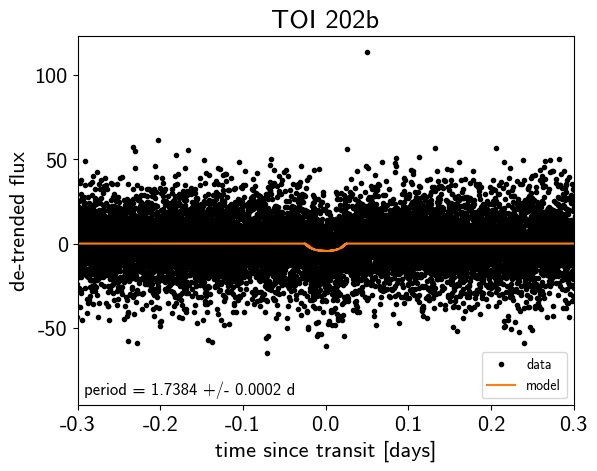

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

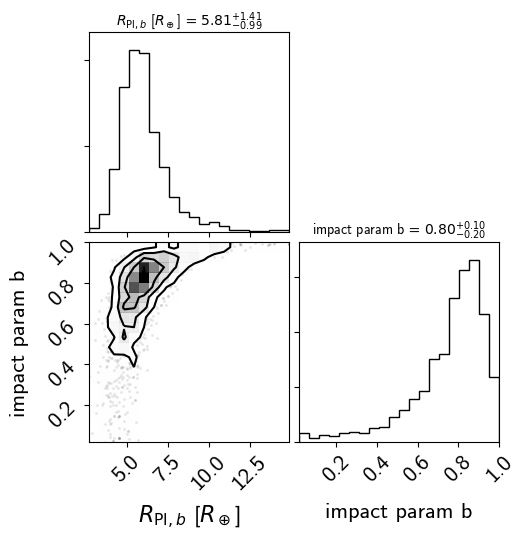

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

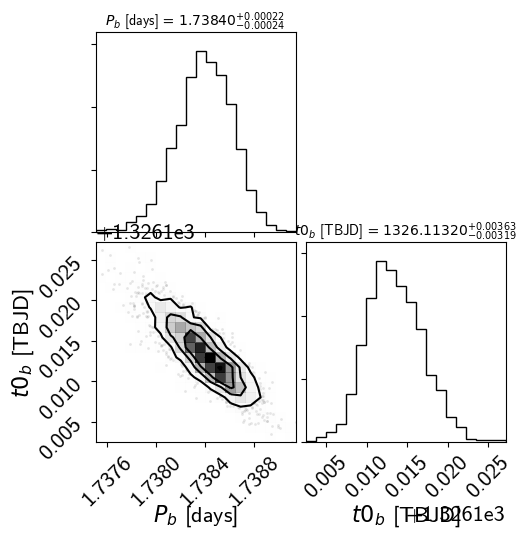

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

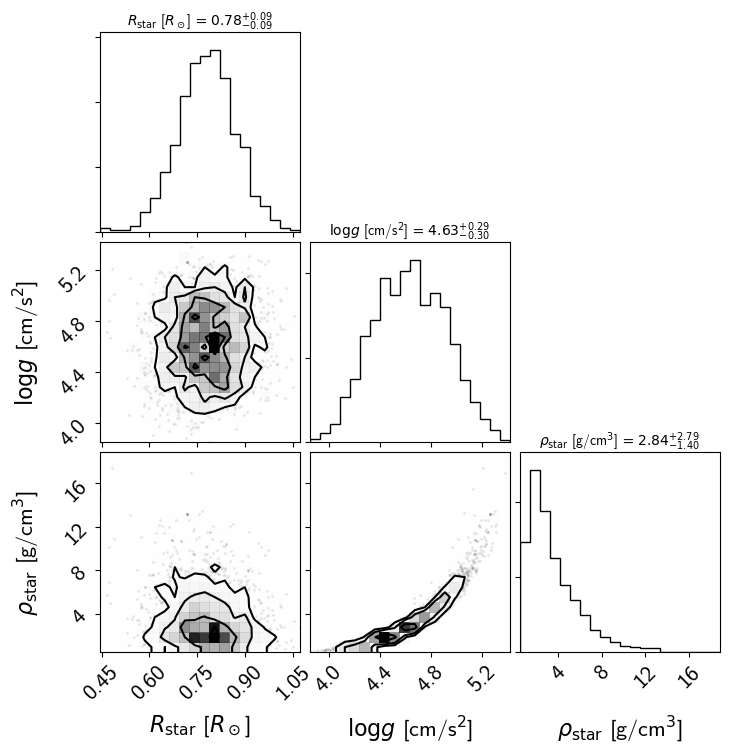

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0


  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py37_0
  - ncurses=6.1=he6710b0_1
  - numpy=1.16.2=py37h7e9f1db_0
  - numpy-base=1.16.2=py37hde5b4d6_0
  - openssl=1.1.1b=h7b6447c_1
  - pandas=0.24.2=py37he6710b0_0
  - pcre=8.43=he6710b0_0
  - pip=19.0.3=py37_0
  - pluggy=0.9.0=py37_0
  - psutil=5.6.1=py37h7b6447c_0
  - py=1.8.0=py37_0
  - pyparsing=2.3.1=py37_0
  - pyqt=5.9.2=py37h05f1152_2
  - pytest=4.3.1=py37_0
  - pytest-arraydiff=0.3=py37h39e3cac_0
  - pytest-astropy=0.5.0=py37_0
  - pytest-doctestplus=0.3.0=py37_0
  - pytest-openfiles=0.3.2=py37_0
  - pytest-remotedata=0.3.1=py37_0
  - python=3.7.3=h037163